In [2]:
import sys
import os

sys.path.append('/gpfs/helios/home/ploter/projects/MultiSensorDropout/')

### Args

In [3]:
import argparse
import torch

args = argparse.Namespace(
    # Basic training parameters
    seed=42,
    batch_size=1,
    epochs=18,
    learning_rate=1e-3,
    learning_rate_backbone=1e-4,
    learning_rate_backbone_names=["backbone"],
    weight_decay=0.01,
    scheduler_step_size=12,
    eval_interval=1,
    patience=5,
    model='perceiver',
    backbone='cnn',  # Set specific value for evaluation
    eval=True,
    weight_loss_center_point=5,
    weight_loss_bce=1,
    shuffle_views=False,
    object_detection=True,  # Set to True for object detection
    resize_frame = None,
    disable_recurrence=False,
    disable_fourier_encoding=False,
    backbone_checkpoint=None,
    
    # Matcher parameters
    set_cost_class=1,
    set_cost_bbox=5,
    set_cost_giou=2,
    focal_alpha=0.25,
    focal_gamma=2,
    
    # Loss coefficients
    bbox_loss_coef=5,
    giou_loss_coef=2,
    eos_coef=0.1,
    
    # Checkpoint parameters
    resume='checkpoint_epoch_17.pth',  # Replace with actual checkpoint path
    output_dir="./output",  # Provide a default output directory
    device='cuda' if torch.cuda.is_available() else 'cpu',
    
    # Dataset parameters
    dataset='moving-mnist-medium',
    dataset_path='Max-Ploter/detection-moving-mnist-medium',
    generate_dataset_runtime=False,
    num_workers=4,
    num_frames=20,
    train_dataset_fraction=1.0,
    train_dataset_size=1.0,  # Additional parameter from notebook
    test_dataset_fraction=1.0,
    frame_dropout_pattern=None,
    view_dropout_probs=[],#[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85],
    sampler_steps=[], #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    sequential_sampler=False,
    grid_size=(1, 1),
    tile_overlap=0.0,
    
    # Wandb parameters
    wandb_project='multi-sensor-dropout',
    wandb_id=None,
    
    # Perceiver model parameters
    num_freq_bands=6,  # Set to 4 as in the notebook
    max_freq=10, 
    enc_layers=1,
    num_queries=16,  # Set to 16 as in the notebook
    hidden_dim=128,
    enc_nheads_cross=1,
    nheads=1,
    dropout=0.0,
    self_per_cross_attn=1,
    multi_classification_heads=False,
    input_axis=2,
    
    # LSTM model parameters
    lstm_hidden_size=128,
    
    # Additional parameters for complete compatibility
    focal_loss=True,
)

In [4]:
class DummyCriterion:
    def __init__(self, device):
        # Initialize with the necessary attributes
        self.device = device
        self.weight_dict = {'loss_ce': 1}
        
    def __call__(self, outputs, targets, *args, **kwargs):
        # Return a dictionary with zero losses to maintain the expected interface
        return {
            'loss_ce': torch.tensor(0.0, device=self.device),
            'loss_bbox': torch.tensor(0.0, device=self.device),
            'loss_giou': torch.tensor(0.0, device=self.device),
            'loss': torch.tensor(0.0, device=self.device)
        }

In [5]:
import torch
from torch import nn

class PostProcessTopK(nn.Module):
    """ Wrapper that applies a post-processor and keeps only the top-k predictions by score and a score threshold """

    def __init__(self, post_processor, top_k=10, score_threshold=0.5):
        super().__init__()
        self.post_processor = post_processor
        self.top_k = top_k
        self.score_threshold = score_threshold

    @torch.no_grad()
    def forward(self, outputs, target_sizes):
        # Get results from the original post processor
        results = self.post_processor(outputs, target_sizes)

        # Filter to keep only top-k results and results above the score threshold
        filtered_results = []
        for result in results:
            scores, labels, boxes = result['scores'], result['labels'], result['boxes']

            # Get top-k indices by score
            top_k = min(self.top_k, len(scores))
            if top_k > 0:  # Check if there are any predictions
                top_indices = torch.topk(scores, top_k).indices

                # Filter by top-k indices
                top_scores = scores[top_indices]
                top_labels = labels[top_indices]
                top_boxes = boxes[top_indices]

                # Filter by score threshold
                threshold_indices = top_scores >= self.score_threshold
                final_scores = top_scores[threshold_indices]
                final_labels = top_labels[threshold_indices]
                final_boxes = top_boxes[threshold_indices]

                filtered_results.append({'scores': final_scores, 'labels': final_labels, 'boxes': final_boxes})
            else:
                # Keep empty result if no predictions
                filtered_results.append({'scores': torch.empty(0), 'labels': torch.empty(0, dtype=torch.int64), 'boxes': torch.empty(0, 4)})

        return filtered_results

### Seq NMS post processor

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F # Required for softmax

# Try to import seq_nms from the pt_seq_nms library
try:
    from pt_seq_nms import seq_nms
except ImportError:
    print("Warning: 'pt_seq_nms' library not found or 'seq_nms' function is missing.")
    print("SeqNMSEvaluationPostprocessor will not function correctly.")
    print("Ensure the library is installed: pip install git+https://github.com/MrParosk/seq_nms.git")
    seq_nms = None

# Attempt to import box_ops, usually from a 'util' module in DETR-like projects
try:
    from util import box_ops # Assuming box_ops.box_cxcywh_to_xyxy is available
except ImportError:
    print("Warning: 'util.box_ops' not found. Box conversion utilities (box_cxcywh_to_xyxy) will be missing.")
    print("Ensure you have a 'util.box_ops' module with 'box_cxcywh_to_xyxy' or provide an alternative.")
    box_ops = None


class SeqNMSEvaluationPostprocessor(nn.Module):
    """
    Applies Sequence Non-Maximum Suppression (Seq-NMS) using the `seq_nms` function
    and incorporates the logic for converting raw model outputs to the final
    detection format directly within this class.

    The output per frame will retain NumQueries entries, with scores modified by Seq-NMS.
    """
    def __init__(self,
                 min_score_threshold: float = 0.01, # Score threshold applied BEFORE Seq-NMS
                 linkage_threshold: float = 0.5,
                 iou_threshold: float = 0.5):
        """
        Initializes the SeqNMSEvaluationPostprocessor.

        Args:
            min_score_threshold (float): Minimum confidence score for a detection's
                                         initial score to be considered by `seq_nms`
                                         (scores below this are set to 0 before `seq_nms`).
                                         Defaults to 0.01.
            linkage_threshold (float): The linkage threshold for Seq-NMS. Defaults to 0.5.
            iou_threshold (float): The IoU threshold for Seq-NMS. Defaults to 0.5.

        Raises:
            ImportError: If the 'pt_seq_nms.seq_nms' or 'util.box_ops' cannot be imported.
        """
        super().__init__()
        if seq_nms is None:
            raise ImportError("'pt_seq_nms.seq_nms' function is required but could not be imported.")
        if box_ops is None: # Ensure box_ops is available for coordinate conversions
            raise ImportError("'util.box_ops' module with 'box_cxcywh_to_xyxy' is required for box conversion.")

        self.min_score_threshold = min_score_threshold
        self.linkage_threshold = linkage_threshold
        self.iou_threshold = iou_threshold
        print(f"Initialized SeqNMSEvaluationPostprocessor (Integrated PostProcessing, NumQueries output) with: "
              f"min_score_thresh_pre_seqnms={min_score_threshold}, "
              f"linkage_thresh={linkage_threshold}, iou_thresh={iou_threshold}")

    @torch.no_grad()
    def forward(self, outputs: dict, target_sizes: torch.Tensor) -> list[dict]:
        """
        Processes model output: prepares data for Seq-NMS by converting raw outputs,
        applies Seq-NMS, and then formats the final list of detections, maintaining
        NumQueries entries per frame.

        Args:
            outputs (dict): Raw output from the video object detector. Expected keys:
                             - 'pred_logits': Tensor [T, NumQueries, NumClasses+1]
                             - 'pred_boxes': Tensor [T, NumQueries, 4] (relative cxcywh)
                             Where T is the number of frames.
            target_sizes (torch.Tensor): Shape [T, 2], original (height, width) per frame.

        Returns:
            list[dict]: A list of T dictionaries (one per frame). Each dict contains:
                        - 'scores': Tensor [NumQueries], scores after Seq-NMS (suppressed ~0).
                        - 'labels': Tensor [NumQueries], original labels for each query.
                        - 'boxes': Tensor [NumQueries, 4] (absolute xyxy) for each query.
        """
        pred_logits_seq = outputs.get('pred_logits')
        pred_boxes_seq = outputs.get('pred_boxes') # Relative cxcywh

        # --- Input Validation ---
        if pred_logits_seq is None or pred_boxes_seq is None:
            raise KeyError("Input 'outputs' must contain 'pred_logits' and 'pred_boxes'.")
        if not (isinstance(pred_logits_seq, torch.Tensor) and isinstance(pred_boxes_seq, torch.Tensor)):
             raise TypeError("'pred_logits' and 'pred_boxes' must be torch tensors.")
        if pred_logits_seq.dim() != 3 or pred_boxes_seq.dim() != 3:
             raise ValueError(f"Expected 3D tensors for logits and boxes [T, NumQueries, Dim], "
                              f"got {pred_logits_seq.shape} and {pred_boxes_seq.shape}")
        if pred_logits_seq.shape[0:2] != pred_boxes_seq.shape[0:2]:
             raise ValueError(f"Shape mismatch (T, NumQueries) between 'pred_logits' {pred_logits_seq.shape} "
                              f"and 'pred_boxes' {pred_boxes_seq.shape}")

        num_frames = pred_logits_seq.shape[0]
        num_queries = pred_logits_seq.shape[1]
        device = pred_logits_seq.device
        
        # Print the number of initial predictions
        # print(f"SeqNMSEvaluationPostprocessor: Received {num_frames} frames, each with {num_queries} initial prediction slots. Total slots: {num_frames * num_queries}")

        if not isinstance(target_sizes, torch.Tensor):
             raise TypeError("'target_sizes' must be a torch tensor.")
        if target_sizes.shape != (num_frames, 2):
            raise ValueError(f"Expected 'target_sizes' shape [{num_frames}, 2], got {target_sizes.shape}")

        # --- 1. Prepare inputs for Seq-NMS (absolute boxes, initial scores, labels) ---
        all_abs_boxes_for_seq_nms = []
        all_masked_scores_for_seq_nms = []
        all_labels_for_seq_nms = [] # Stores original labels corresponding to scores/boxes

        for t in range(num_frames):
            logits_t = pred_logits_seq[t]  # [NumQueries, NumClasses+1]
            boxes_rel_t = pred_boxes_seq[t] # [NumQueries, 4] (cxcywh)
            img_h, img_w = target_sizes[t]

            # Convert relative boxes to absolute xyxy for seq_nms
            abs_boxes_t = box_ops.box_cxcywh_to_xyxy(boxes_rel_t)
            scale_fct = torch.tensor([img_w, img_h, img_w, img_h], device=device, dtype=torch.float)
            abs_boxes_t = abs_boxes_t * scale_fct

            # Get initial scores and labels from logits (mimicking PostProcess)
            prob_t = F.softmax(logits_t, -1)
            scores_t, labels_t = prob_t[..., :-1].max(-1) # Max over foreground classes

            # Apply min_score_threshold to scores before passing to seq_nms
            scores_masked_t = scores_t.clone()
            scores_masked_t[scores_t < self.min_score_threshold] = 0.0

            all_abs_boxes_for_seq_nms.append(abs_boxes_t)
            all_masked_scores_for_seq_nms.append(scores_masked_t)
            all_labels_for_seq_nms.append(labels_t) # Store original labels

        if not all_abs_boxes_for_seq_nms:
            return [] # Should only happen if num_frames is 0

        stacked_abs_boxes = torch.stack(all_abs_boxes_for_seq_nms)
        stacked_masked_scores = torch.stack(all_masked_scores_for_seq_nms)
        stacked_original_labels = torch.stack(all_labels_for_seq_nms)


        # --- 2. Apply Seq-NMS ---
        # updated_scores_from_seq_nms will have shape [T, NumQueries]
        # Scores for suppressed boxes are expected to be 0 or very low.
        try:
            updated_scores_from_seq_nms = seq_nms(
                boxes=stacked_abs_boxes,
                scores=stacked_masked_scores,
                classes=stacked_original_labels.to(torch.int32), # CAST TO INT32
                linkage_threshold=self.linkage_threshold,
                iou_threshold=self.iou_threshold
            )
        except Exception as e:
             print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
             print(f"Error occurred during 'seq_nms' execution: {e}")
             print(f"Inputs shapes to seq_nms:")
             print(f"  stacked_abs_boxes: {stacked_abs_boxes.shape}")
             print(f"  stacked_masked_scores: {stacked_masked_scores.shape}")
             print(f"  stacked_original_labels: {stacked_original_labels.shape} (dtype before cast: {stacked_original_labels.dtype})")
             print(f"Proceeding by using pre-SeqNMS scores (Seq-NMS is effectively bypassed).")
             print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
             # Fallback: use scores that went into seq_nms if seq_nms fails
             updated_scores_from_seq_nms = stacked_masked_scores

        # --- 3. Format Final Results, maintaining NumQueries dimension ---
        final_results_list = []
        for t in range(num_frames):
            # These are the scores after Seq-NMS (or fallback), shape [NumQueries]
            final_scores_t = updated_scores_from_seq_nms[t]

            # Corresponding original labels and absolute boxes for all NumQueries slots
            final_labels_t = stacked_original_labels[t] # Shape [NumQueries]
            final_boxes_t = stacked_abs_boxes[t]        # Shape [NumQueries, 4]

            final_results_list.append({
                'scores': final_scores_t,
                'labels': final_labels_t,
                'boxes': final_boxes_t
            })

        return final_results_list


## Recurrent module

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F # Needed for padding

class RecurrentVideoObjectModule(nn.Module):
    """
    Refactored module using a YOLO detector, producing output compatible
    with the original implementation's format {'pred_logits': Tensor, 'pred_boxes': Tensor}.
    Detections from each frame are padded to a maximum number before stacking.
    Includes fix for grayscale input.
    """
    def __init__(self,
                 detector_module: nn.Module, # E.g., a loaded YOLO model
                 num_classes: int = 10, # Needed for converting scores/classes to logits

                ):
        super().__init__()
        self.detector_module = detector_module
        self.num_classes = num_classes + 1
        # Store the number of foreground classes if needed elsewhere
        self.num_foreground_classes = num_classes

    @torch.no_grad() # Crucial for evaluation/inference mode
    def forward(self, samples, targets: list = None):
        """
        Processes video frames sequentially, collects raw detections, pads them
        to the maximum number of detections found in any frame, and stacks them.
        Handles potential grayscale input.

        Args:
            samples (torch.Tensor): Input video tensor (B, T, C, H, W).
                                    Module assumes B=1. Can handle C=1 or C=3.
            targets (list): List containing target dictionaries for the video.
                            Passed through unmodified.

        Returns:
            tuple[dict, list]:
                - dict: {'pred_logits': Tensor [T, MaxDetsPerFrame, NumClasses],
                         'pred_boxes': Tensor [T, MaxDetsPerFrame, 4]}
                         Padded and stacked detections across all frames.
                - list: The original targets list (passed through).
        """
        if samples.dim() != 5:
             raise ValueError(f"Expected input tensor with 5 dimensions (B, T, C, H, W), but got {samples.dim()}")

        if samples.shape[0] != 1:
            print(f"Warning: RecurrentVideoObjectModule expects batch size 1, but got {samples.shape[0]}. Processing only the first item.")
            samples = samples[:1]

        # samples shape: (B, T, C, H, W), B=1 assumed
        num_frames = samples.shape[1]
        src = samples.permute(1, 0, 2, 3, 4).squeeze(1) # Shape: (T, C, H, W)
        device = samples.device
        input_channels = src.shape[1] # Get the number of channels C

        # Check if input is grayscale (C=1) or color (C=3)
        if input_channels not in [1, 3]:
            raise ValueError(f"Expected input frames to have 1 or 3 channels, but got {input_channels}")

        logits_accumulator = []
        boxes_accumulator = []
        max_detections = 0 # Keep track of the maximum number of detections in any frame

        if isinstance(self.detector_module, nn.Module):
              self.detector_module.eval()

        predictions = []
        
        for timestamp, frame in enumerate(src): # Iterate through frames (C, H, W)

            # --- Ensure 3 Channels for YOLO ---
            if input_channels == 1:
                # Repeat the grayscale channel 3 times
                frame = frame.repeat(3, 1, 1) # Shape becomes (3, H, W)

            frame_batch = frame.unsqueeze(0) # Add batch dimension (1, 3, H, W)

            # --- Run Detector (YOLO) ---
            try:
                with torch.no_grad():
                    # Use model.predict for easier handling of results and NMS
                    # Adjust conf/iou as needed for your specific detector/task
                    detector_preds = self.detector_module.predict(frame_batch, conf=0.001, iou=0.8, device=device, verbose=False)
                    # 'preds' is typically a list of Results objects, one per image

            except Exception as e:
                print(f"Error during detector_module.predict on frame {timestamp}: {e}")
                print("Skipping frame due to prediction error.")
                # Decide how to handle: continue, raise, or append empty tensors?
                # Appending empty tensors might be safer for padding later.
                # logits_accumulator.append(torch.empty((0, self.num_classes), device=device))
                # boxes_accumulator.append(torch.empty((0, 4), device=device))
                raise e

            # --- Process Detections ---
            results_obj = detector_preds[0] # Assuming batch size 1 for predict


            # Use normalized xywh format directly if available
            frame_boxes_cxcywh = results_obj.boxes.xywhn.to(device)

            # print(f"frame_boxes_cxcywh: {frame_boxes_cxcywh.shape}")
            
            frame_scores = results_obj.boxes.conf.to(device)

            # print(f"frame_scores: {frame_scores.shape}")
            # print(frame_scores)
            
            frame_classes = results_obj.boxes.cls.to(device).long()

            # print(f"frame_classes: {frame_classes.shape}")

            predictions.append({
                'scores': frame_scores,
                'labels': frame_classes,
                'boxes': frame_boxes_cxcywh,
                })

            num_detections = frame_classes.shape[0]

            # print(f"num_detections: {num_detections}")

            # --- Convert scores/classes to approximate logits ---
            frame_logits = torch.zeros((num_detections, self.num_classes), device=device)
            
            # Place the score logits at the correct class index
            frame_logits[torch.arange(num_detections, device=device), frame_classes] = frame_scores
            
            logits_accumulator.append(frame_logits)
            boxes_accumulator.append(frame_boxes_cxcywh)

            # Update max detections found so far
            if num_detections > max_detections:
                max_detections = num_detections

        # --- Pad tensors to max_detections ---
        padded_logits = []
        padded_boxes = []
        pad_val_boxes = 0.0
        background_class_index = self.num_classes - 1 # Last index is background
        for frame_logits, frame_boxes in zip(logits_accumulator, boxes_accumulator):
            num_dets = frame_logits.shape[0]
            pad_size = max_detections - num_dets

            if pad_size > 0:
                # --- Pad logits ---
                # Create padding with 0.0 everywhere first
                logit_padding = torch.zeros((pad_size, self.num_classes), device=device, dtype=frame_logits.dtype)
                # Set the background class logit to +inf for padded entries
                logit_padding[:, background_class_index] = float('inf')
                # Concatenate original logits with the padding
                padded_frame_logits = torch.cat((frame_logits, logit_padding), dim=0)

                # --- Pad boxes ---
                # Pad boxes with 0.0
                box_padding = torch.full((pad_size, 4), pad_val_boxes, device=device, dtype=frame_boxes.dtype)
                # Concatenate original boxes with the padding
                padded_frame_boxes = torch.cat((frame_boxes, box_padding), dim=0)
            else:
                # No padding needed if already max_detections
                padded_frame_logits = frame_logits
                padded_frame_boxes = frame_boxes

            padded_logits.append(padded_frame_logits)
            padded_boxes.append(padded_frame_boxes)


        final_logits = torch.stack(padded_logits) # Shape: [T, max_detections, num_classes]
        final_boxes = torch.stack(padded_boxes)   # Shape: [T, max_detections, 4]

        result = {
            'pred_logits': final_logits,
            'pred_boxes': final_boxes,
            'predictions': predictions
        }

        return result, targets[0]

    def eval(self):
        """Sets the detector module to evaluation mode."""
        if isinstance(self.detector_module, nn.Module):
            self.detector_module.eval()
        return self

class YoloPostProcess(nn.Module):
    """ This module converts the model's output into the format expected by the coco api"""
    def __init__(self):
        super().__init__()

    @torch.no_grad()
    def forward(self, outputs, target_sizes):
        """ Perform the computation
        Parameters:
            outputs: raw outputs of the model
            target_sizes: tensor of dimension [batch_size x 2] containing the size of each images of the batch
                          For evaluation, this must be the original image size (before any data augmentation)
                          For visualization, this should be the image size after data augment, but before padding
        """
        
        predictions = outputs['predictions']

        assert len(predictions) == len(target_sizes)
        assert target_sizes.shape[1] == 2
        results = []

        for frame_preds, size in zip(predictions, target_sizes):
            scores = frame_preds['scores']  # Tensor of scores for this frame
            labels = frame_preds['labels']  # Tensor of labels for this frame
            boxes_norm = frame_preds['boxes'] # Normalized [cx, cy, w, h] boxes
            boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes_norm)

            # 2. Scale boxes to the original image size
            img_h, img_w = size
            scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=0).to(boxes_xyxy.device)
            scaled_boxes = boxes_xyxy * scale_fct
            
            results.append({'scores': scores, 'labels': labels, 'boxes': scaled_boxes})
                
        return results


## MAP Evaluator

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import numpy as np
# Assuming box_ops contains the necessary bounding box utility functions like box_cxcywh_to_xyxy
# Import the actual box_ops module
from util import box_ops
# Assuming PostProcess is importable, e.g.:
# from models.perceiver import PostProcess # Adjust import path as needed
# Assuming box_iou is available from torchvision.ops
from torchvision.ops import box_iou


class MeanAveragePrecisionEvaluator:
    """
    Computes Mean Average Precision (mAP) for object detection tasks using a provided postprocessor.
    Also computes separate mAP scores for:
    1. Predictions matched to overlapping ground truth objects.
    2. Predictions matched to ground truth objects near the frame boundary.

    Processes model outputs assuming shape [sequence_length, num_queries, ...] and targets_flat
    as a list of dictionaries of length sequence_length.

    Standard mAP is updated per timestamp. Overlap and Boundary mAP use results
    from a single matcher call performed once per sequence.
    """
    def __init__(self, device, postprocessor, matcher, box_format='xyxy', iou_thresholds=None, overlap_iou_threshold=0.01, boundary_pixel_tolerance=0):
        """
        Initializes the mAP evaluator.

        Parameters:
        device (torch.device): The device to run computations on (e.g., 'cuda', 'cpu').
        postprocessor (torch.nn.Module): Postprocessing module (e.g., PostProcess).
        matcher (torch.nn.Module): Matcher instance (e.g., HungarianMatcher). Assumed to handle
                                   sequence dim as batch dim or be adapted accordingly.
        box_format (str): Box format for torchmetrics ('xyxy').
        iou_thresholds (list, optional): IoU thresholds for mAP calculation.
        overlap_iou_threshold (float): Min IoU between two GT boxes to be considered overlapping.
        boundary_pixel_tolerance (int): Pixel distance from edge to consider a GT box as 'on boundary'.
        """
        self.device = device
        self.postprocessor = postprocessor.to(self.device)
        self.matcher = matcher # Store matcher instance
        self.overlap_iou_threshold = overlap_iou_threshold
        self.boundary_pixel_tolerance = boundary_pixel_tolerance

        # --- Initialize Metrics ---
        self.map_metric = torchmetrics.detection.MeanAveragePrecision(
            box_format='xyxy', iou_type='bbox', iou_thresholds=iou_thresholds
        ).to(self.device)
        self.map_results = None

        self.map_metric_overlap = torchmetrics.detection.MeanAveragePrecision(
            box_format='xyxy', iou_type='bbox', iou_thresholds=iou_thresholds
        ).to(self.device)
        self.map_results_overlap = None

        self.map_metric_boundary = torchmetrics.detection.MeanAveragePrecision(
            box_format='xyxy', iou_type='bbox', iou_thresholds=iou_thresholds
        ).to(self.device)
        self.map_results_boundary = None

        # --- Initialize GT Counts ---
        self.count_total_gt = 0
        self.count_overlap_gt = 0
        self.count_boundary_gt = 0


    # Helper function provided by user (might need adjustment based on actual matcher output format)
    def _get_src_permutation_idx(self, indices):
      # This helper might not be directly usable if indices is now a list over sequence length
      # The logic using matcher results below accesses indices[t] directly.
      print("Warning: _get_src_permutation_idx might not be suitable for the new matcher output format.")
      # Placeholder return if called unexpectedly
      return torch.tensor([], dtype=torch.long), torch.tensor([], dtype=torch.long)


    def update(self, outputs, targets_flat):
        """
        Updates the evaluator state. Standard mAP is updated per timestamp.
        Matcher runs once per sequence. Overlap/Boundary metrics are updated
        per timestamp using the single matcher result.

        Parameters:
        outputs (dict): Raw outputs. Keys: 'pred_logits', 'pred_boxes'. Shape [seq_len, num_queries, ...].
        targets_flat (list[dict]): GT dicts. Len=seq_len. Keys: 'orig_size', 'boxes', 'labels'.
        """
        # --- Input Validation ---
        if not isinstance(targets_flat, list): return
        if 'pred_logits' not in outputs or 'pred_boxes' not in outputs: return

        pred_logits_seq = outputs['pred_logits'].to(self.device) # Shape [seq_len, num_queries, ...]
        pred_boxes_seq = outputs['pred_boxes'].to(self.device)   # Shape [seq_len, num_queries, ...]
        seq_len = pred_logits_seq.shape[0]

        if pred_logits_seq.dim() < 2 or seq_len != len(targets_flat):
             print(f"Error: Mismatch/Shape issue between outputs ({pred_logits_seq.shape}) and targets_flat ({len(targets_flat)}). Skipping.")
             return

        # --- Store per-timestamp processed data ---
        all_postprocessed_preds = []
        all_processed_targets = []
        all_orig_sizes = [] # Store original sizes (tensor[2]) for boundary check

        # --- First Pass: Update Standard mAP & Prepare Data ---
        for t in range(seq_len):
            target_dict = targets_flat[t]
            if not isinstance(target_dict, dict) or not all(k in target_dict for k in ['orig_size', 'boxes', 'labels']):
                 print(f"Error: Invalid target dict at timestamp {t}. Skipping timestamp.")
                 all_postprocessed_preds.append(None)
                 all_processed_targets.append(None)
                 all_orig_sizes.append(None)
                 continue

            # Prepare Predictions (Post-processed)
            orig_size_tensor_t = None
            prediction_dict_postprocessed_t = None
            try:
                orig_size_tensor_t = target_dict['orig_size'].to(self.device)
                if orig_size_tensor_t.shape != (2,): raise ValueError("Incorrect orig_size shape")
                orig_target_size_tensor_batch = orig_size_tensor_t.unsqueeze(0) # Shape [1, 2]

                outputs_raw_t_batch = { # Need batch dim for postprocessor
                    'pred_logits': pred_logits_seq[t].unsqueeze(0),
                    'pred_boxes': pred_boxes_seq[t].unsqueeze(0)
                }
                with torch.no_grad():
                    predictions_postprocessed_t_list = self.postprocessor(outputs_raw_t_batch, orig_target_size_tensor_batch)
                if len(predictions_postprocessed_t_list) != 1: raise RuntimeError("Postprocessor failed")
                prediction_dict_postprocessed_t = predictions_postprocessed_t_list[0]
                all_postprocessed_preds.append(prediction_dict_postprocessed_t)
                all_orig_sizes.append(orig_size_tensor_t) # Store shape [2] tensor

            except Exception as e:
                 print(f"Error processing predictions for timestamp {t}: {e}. Skipping.")
                 all_postprocessed_preds.append(None)
                 all_processed_targets.append(None)
                 all_orig_sizes.append(None)
                 continue

            # Prepare Targets (Absolute xyxy)
            target_dict_processed_t = None
            try:
                target_dict_device = {k: v.to(self.device) for k, v in target_dict.items() if isinstance(v, torch.Tensor)}
                img_h_target_tensor = orig_size_tensor_t[0]
                img_w_target_tensor = orig_size_tensor_t[1]
                scale_fct_target = torch.stack([img_w_target_tensor, img_h_target_tensor, img_w_target_tensor, img_h_target_tensor], dim=0)

                boxes_target = target_dict_device['boxes'] # Assumed relative cxcywh
                labels_target = target_dict_device['labels'] # Original labels

                gt_boxes_xyxy = torch.empty((0,4), device=self.device) # Default empty boxes
                labels_final = torch.empty(0, dtype=torch.long, device=self.device) # Default empty labels

                if boxes_target.numel() > 0:
                     # Only process boxes and use original labels if boxes exist
                     gt_boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes_target) * scale_fct_target
                     # Ensure labels correspond to the boxes processed
                     if labels_target.shape[0] == boxes_target.shape[0]:
                          labels_final = labels_target
                     else:
                          print(f"Warning: Mismatch between number of boxes ({boxes_target.shape[0]}) and labels ({labels_target.shape[0]}) at timestamp {t}. Using empty labels.")
                          # Keep labels_final empty if mismatch occurs
                # else: gt_boxes_xyxy and labels_final remain empty

                target_dict_processed_t = {
                    'boxes': gt_boxes_xyxy, # Shape [N, 4] or [0, 4]
                    'labels': labels_final   # Shape [N] or [0]
                }
                all_processed_targets.append(target_dict_processed_t)

                # --- Update Total GT Count ---
                if gt_boxes_xyxy.numel() > 0: # Count only if there are GT boxes
                    self.count_total_gt += gt_boxes_xyxy.shape[0]
            except Exception as e:
                 print(f"Error preparing targets for timestamp {t}: {e}. Skipping.")
                 all_processed_targets.append(None)
                 if len(all_postprocessed_preds) > len(all_processed_targets):
                      all_postprocessed_preds.pop()
                      all_orig_sizes.pop()
                 continue

            # Update Standard mAP Metric for this timestamp
            # Ensure both prediction and target dicts are valid before updating
            if prediction_dict_postprocessed_t is not None and target_dict_processed_t is not None:
                try:
                    self.map_metric.update([prediction_dict_postprocessed_t], [target_dict_processed_t])
                except Exception as e:
                    print(f"Error updating standard mAP metric for timestamp {t}: {e}")
            else:
                 print(f"Skipping standard mAP update for timestamp {t} due to previous errors.")


        # --- Run Matcher ONCE for the whole sequence ---
        indices_seq = None # Will store list of tuples: [(pred_idx_t, gt_idx_t)] * seq_len
        try:
            # Prepare inputs for matcher (treating sequence as batch)
            outputs_raw_seq = {'pred_logits': pred_logits_seq, 'pred_boxes': pred_boxes_seq}
            # Ensure targets are on device and have required keys
            targets_flat_device = []
            valid_targets_exist = False
            for t_idx, td in enumerate(targets_flat):
                 # Use the already processed targets if available and valid
                 processed_target = all_processed_targets[t_idx]
                 if processed_target is not None and isinstance(processed_target.get('boxes'), torch.Tensor) and isinstance(processed_target.get('labels'), torch.Tensor):
                      # Matcher might expect original format, re-prepare if necessary
                      # For simplicity, let's assume matcher works with processed targets (abs xyxy)
                      # If matcher needs relative cxcywh, re-fetch from targets_flat
                      original_target = targets_flat[t_idx]
                      if isinstance(original_target, dict) and all(k in original_target for k in ['boxes', 'labels']):
                           targets_flat_device.append({k: v.to(self.device) for k, v in original_target.items() if k in ['boxes', 'labels']})
                           valid_targets_exist = True
                      else:
                           # Add placeholder if original target was invalid
                           targets_flat_device.append({'boxes': torch.empty((0,4), device=self.device), 'labels': torch.empty(0, dtype=torch.long, device=self.device)})

                 else:
                      # Add placeholder if processing failed
                      targets_flat_device.append({'boxes': torch.empty((0,4), device=self.device), 'labels': torch.empty(0, dtype=torch.long, device=self.device)})


            if valid_targets_exist: # Only run matcher if there's something to match
                 with torch.no_grad():
                      # Assumes matcher takes [Seq, N, C] outputs and List[Dict] targets (len=Seq)
                      indices_seq = self.matcher(outputs_raw_seq, targets_flat_device)
            else:
                 print("Skipping matcher run as no valid targets were found in the sequence.")

        except Exception as e:
             print(f"Error running matcher for the sequence: {e}")
             indices_seq = None # Ensure indices_seq is None if matcher fails

        # --- Second Pass: Update Overlap and Boundary Metrics ---
        if indices_seq is not None and len(indices_seq) == seq_len: # Check if matcher ran successfully and returned expected length
            for t in range(seq_len):
                # Retrieve pre-processed data for timestamp t
                prediction_dict_postprocessed_t = all_postprocessed_preds[t]
                target_dict_processed_t = all_processed_targets[t]
                orig_size_tensor_t = all_orig_sizes[t]

                # Skip if data preparation failed in the first pass for this timestamp
                if prediction_dict_postprocessed_t is None or target_dict_processed_t is None or orig_size_tensor_t is None:
                    continue

                # Get matcher results for this specific timestamp
                # Add check for empty matcher results for this timestamp
                if t >= len(indices_seq) or not indices_seq[t] or len(indices_seq[t]) != 2:
                     # print(f"Matcher results missing or invalid for timestamp {t}. Skipping overlap/boundary.")
                     continue # Skip if no valid match for this frame
                #matched_pred_indices_t, matched_gt_indices_t = indices_seq[t]
                matched_pred_indices_t = indices_seq[t][0].to(self.device)
                matched_gt_indices_t = indices_seq[t][1].to(self.device)

                gt_boxes_xyxy = target_dict_processed_t['boxes']
                num_gt = gt_boxes_xyxy.shape[0]

                # --- Overlap Calculation ---
                if num_gt > 1: # Overlap requires at least 2 GT boxes
                    try:
                        gt_iou_matrix = box_iou(gt_boxes_xyxy, gt_boxes_xyxy)
                        gt_iou_matrix.fill_diagonal_(0)
                        overlaps_exist = (gt_iou_matrix > self.overlap_iou_threshold).any(dim=1)
                        overlap_gt_indices = torch.where(overlaps_exist)[0].to(self.device)

                        if overlap_gt_indices.numel() > 0:
                            self.count_overlap_gt += overlap_gt_indices.numel() # Add count of GTs involved in overlap
                            targets_overlap = {
                                'boxes': gt_boxes_xyxy[overlap_gt_indices],
                                'labels': target_dict_processed_t['labels'][overlap_gt_indices]
                            }
                            if matched_pred_indices_t.numel() > 0: # Check if matcher found matches for this frame
                                is_overlap_match = torch.isin(matched_gt_indices_t, overlap_gt_indices)
                                pred_indices_for_overlap = matched_pred_indices_t[is_overlap_match]
                                if pred_indices_for_overlap.numel() > 0:
                                    predictions_overlap = {
                                        'scores': prediction_dict_postprocessed_t['scores'][pred_indices_for_overlap],
                                        'labels': prediction_dict_postprocessed_t['labels'][pred_indices_for_overlap],
                                        'boxes': prediction_dict_postprocessed_t['boxes'][pred_indices_for_overlap],
                                    }
                                    self.map_metric_overlap.update([predictions_overlap], [targets_overlap])
                    except Exception as e:
                        print(f"Error calculating/updating overlap mAP for timestamp {t}: {e}")

                # --- Boundary Calculation ---
                if num_gt > 0: # Boundary check needs at least 1 GT box
                     try:
                        img_h_target_tensor = orig_size_tensor_t[0]
                        img_w_target_tensor = orig_size_tensor_t[1]
                        xmin, ymin, xmax, ymax = gt_boxes_xyxy.unbind(-1)
                        tol = self.boundary_pixel_tolerance
                        is_on_boundary = (xmin <= tol) | (ymin <= tol) | \
                                         (xmax >= img_w_target_tensor - tol) | (ymax >= img_h_target_tensor - tol)
                        boundary_gt_indices = torch.where(is_on_boundary)[0].to(self.device)

                        if boundary_gt_indices.numel() > 0:
                            self.count_boundary_gt += boundary_gt_indices.numel() # Add count of GTs on boundary
                            targets_boundary = {
                                'boxes': gt_boxes_xyxy[boundary_gt_indices],
                                'labels': target_dict_processed_t['labels'][boundary_gt_indices]
                            }
                            if matched_pred_indices_t.numel() > 0: # Check if matcher found matches for this frame
                                is_boundary_match = torch.isin(matched_gt_indices_t, boundary_gt_indices)
                                pred_indices_for_boundary = matched_pred_indices_t[is_boundary_match]
                                if pred_indices_for_boundary.numel() > 0:
                                    predictions_boundary = {
                                        'scores': prediction_dict_postprocessed_t['scores'][pred_indices_for_boundary],
                                        'labels': prediction_dict_postprocessed_t['labels'][pred_indices_for_boundary],
                                        'boxes': prediction_dict_postprocessed_t['boxes'][pred_indices_for_boundary],
                                    }
                                    self.map_metric_boundary.update([predictions_boundary], [targets_boundary])
                     except Exception as e:
                         print(f"Error calculating/updating boundary mAP for timestamp {t}: {e}")
        else:
             print("Matcher did not run successfully or returned unexpected format. Skipping overlap/boundary metric updates.")


    def accumulate(self):
        """
        Computes the final mAP results across all updated timestamps from all sequences.
        Stores the results internally.
        """
        # Accumulate standard mAP
        try:
            self.map_results = self.map_metric.compute()
        except Exception as e:
            print(f"Error computing standard mAP metric: {e}")
            self.map_results = None

        # Accumulate overlap mAP
        try:
            self.map_results_overlap = self.map_metric_overlap.compute()
        except Exception as e:
            print(f"Error computing overlap mAP metric: {e}")
            self.map_results_overlap = None

        # Accumulate boundary mAP
        try:
            self.map_results_boundary = self.map_metric_boundary.compute()
        except Exception as e:
            print(f"Error computing boundary mAP metric: {e}")
            self.map_results_boundary = None


    def summary(self):
        """
        Processes and returns the computed mAP results in a dictionary, including overlap and boundary metrics.
        NOTE: Metrics reflect performance averaged over *all timestamps* processed.

        Returns:
        dict: Dictionary containing scalar mAP results prefixed with 'mAP_', 'mAP_overlap_', and 'mAP_boundary_'.
        """
        summary_dict = {}

        # Add GT Counts
        summary_dict['num_total_gt_objects'] = self.count_total_gt
        summary_dict['num_overlap_gt_objects'] = self.count_overlap_gt
        summary_dict['num_boundary_gt_objects'] = self.count_boundary_gt

        summary_dict['percentage_overlap_gt_objects'] = (self.count_overlap_gt / self.count_total_gt) * 100
        summary_dict['percentage_boundary_gt_objects'] = (self.count_boundary_gt / self.count_total_gt) * 100

        # Process standard mAP results
        if self.map_results is not None:
            print(f"\nRaw mAP Results (Evaluator): {self.map_results}\n")
            for k, v in self.map_results.items():
                if isinstance(v, torch.Tensor) and v.numel() == 1:
                    summary_dict[f'mAP_{k}'] = v.item() # Prefix standard keys
            if not any(k.startswith('mAP_') for k in summary_dict) and self.map_results:
                 if 'map' in self.map_results and self.map_results['map'] == 0: pass
                 else: print("Warning (Evaluator): No scalar standard mAP metrics found.")
        else:
             print("Warning (Evaluator): Standard mAP metric computation failed or produced no results.")

        # Process overlap mAP results
        if self.map_results_overlap is not None:
            print(f"\nRaw Overlap mAP Results (Evaluator): {self.map_results_overlap}\n")
            for k, v in self.map_results_overlap.items():
                if isinstance(v, torch.Tensor) and v.numel() == 1:
                    summary_dict[f'mAP_overlap_{k}'] = v.item() # Prefix overlap keys
            if not any(k.startswith('mAP_overlap_') for k in summary_dict) and self.map_results_overlap:
                 if 'map' in self.map_results_overlap and self.map_results_overlap['map'] == 0: pass
                 else: print("Warning (Evaluator): No scalar overlap mAP metrics found.")
        else:
             print("Warning (Evaluator): Overlap mAP metric computation failed or produced no results.")

        # Process boundary mAP results
        if self.map_results_boundary is not None:
            print(f"\nRaw Boundary mAP Results (Evaluator): {self.map_results_boundary}\n")
            for k, v in self.map_results_boundary.items():
                if isinstance(v, torch.Tensor) and v.numel() == 1:
                    summary_dict[f'mAP_boundary_{k}'] = v.item() # Prefix boundary keys
            if not any(k.startswith('mAP_boundary_') for k in summary_dict) and self.map_results_boundary:
                 if 'map' in self.map_results_boundary and self.map_results_boundary['map'] == 0: pass
                 else: print("Warning (Evaluator): No scalar boundary mAP metrics found.")
        else:
             print("Warning (Evaluator): Boundary mAP metric computation failed or produced no results.")


        return summary_dict

    def reset(self):
        """Resets the internal state of all metrics."""
        self.map_metric.reset()
        self.map_results = None
        self.map_metric_overlap.reset()
        self.map_results_overlap = None
        self.map_metric_boundary.reset()
        self.map_results_boundary = None
        # Reset GT Counts
        self.count_total_gt = 0
        self.count_overlap_gt = 0
        self.count_boundary_gt = 0



In [9]:
import torch
import cv2
import numpy as np
from torchvision import transforms

class Cv2Resize:
    """
    A PyTorch transform to resize a tensor image using OpenCV (cv2).

    This transform converts a PyTorch tensor to a NumPy array, resizes it using
    cv2.resize, and then converts it back to a PyTorch tensor. It handles the
    necessary dimension permutations between PyTorch's (C, H, W) and OpenCV's
    (H, W, C) formats.
    """

    def __init__(self, size, interpolation=cv2.INTER_LINEAR):
        """
        Initializes the transformation.

        Args:
            size (tuple or int): The desired output size. If it's a tuple, it
                                 should be in (height, width) format. If it's an
                                 int, the smaller edge of the image will be matched
                                 to this number, maintaining the aspect ratio.
            interpolation (int, optional): The interpolation method to be used by
                                           cv2.resize. Defaults to cv2.INTER_LINEAR.
        """
        if not isinstance(size, (int, tuple, list)):
            raise TypeError(f"Size must be an int, tuple, or list. Got {type(size)}")
        
        # Ensure size is a tuple for cv2, which expects (width, height)
        if isinstance(size, int):
            self.size = (size, size)
        else:
            # cv2 expects (width, height), but it's more intuitive for users
            # to provide (height, width). We'll swap them for the cv2 function.
            self.size = (size[1], size[0])

        self.interpolation = interpolation

    def __call__(self, img_tensor, target=None):
        """
        Applies the resize transformation.

        Args:
            img_tensor (torch.Tensor): The input image tensor with shape (C, H, W).

        Returns:
            torch.Tensor: The resized image tensor.
        """
        # Ensure the input is a torch tensor
        if not isinstance(img_tensor, torch.Tensor):
            raise TypeError(f"Input should be a torch.Tensor. Got {type(img_tensor)}")

        orig_h, orig_w = img_tensor.shape[-2:]
        
        
        resized_frames = []
        for frame in img_tensor:
            # frame shape is (C, H, W)
            # Permute from (C, H, W) to (H, W, C) for OpenCV
            numpy_frame = frame.cpu().numpy().transpose(1, 2, 0)

            # Resize the single frame
            resized_frame_np = cv2.resize(
                numpy_frame,
                self.size, # self.size is (width, height)
                interpolation=self.interpolation
            )
            
            # Handle grayscale case where channel dimension might be lost
            if resized_frame_np.ndim == 2:
                resized_frame_np = resized_frame_np[:, :, np.newaxis]

            # Permute back from (H, W, C) to (C, H, W) for PyTorch
            transposed_frame = resized_frame_np.transpose(2, 0, 1)
            resized_frames.append(torch.from_numpy(transposed_frame.copy()))

        # Stack the resized frames back into a single tensor
        rescaled_image = torch.stack(resized_frames, dim=0)
        
        if target is None:
            return rescaled_image, None
            
        new_w, new_h = self.size

        ratio_width = float(new_w) / float(orig_w)
        ratio_height = float(new_h) / float(orig_h)
    
        ratios_tensor = torch.tensor([ratio_width, ratio_height, ratio_width, ratio_height])

        updated_targets = []
        for frame_target in target:
        	new_frame_target = frame_target.copy()  # Process copy
    
        	if "boxes" in new_frame_target:
        		boxes = new_frame_target["boxes"]
        		# Ensure boxes is a tensor and not empty before scaling
        		if isinstance(boxes, torch.Tensor) and boxes.numel() > 0:
        			# Move ratios tensor to the same device as boxes before scaling
        			scaled_boxes = boxes * ratios_tensor.to(boxes.device)
        			new_frame_target["boxes"] = scaled_boxes
    
        	updated_targets.append(new_frame_target)
        
        return rescaled_image, updated_targets  # Return list of updated targets

## To COCO JSON

In [10]:
import torch
import json
import os
from pathlib import Path

class CocoJsonEvaluator:
    """
    Accumulates predictions and (optionally) ground truth in COCO format.
    At the end of evaluation, it saves them to JSON files.
    This allows using external tools like pycocotools for metric calculation.
    """

    def __init__(self, postprocessor, output_dir, checkpoint, save_gt=False, categories=None):
        """
        Initializes the CocoJsonEvaluator.

        Args:
            postprocessor: The postprocessor module to convert model outputs to final predictions.
            output_dir (str): Directory where the JSON files will be saved.
            save_gt (bool): If True, saves a ground_truth.json file. Defaults to False.
            categories (list, optional): A list of COCO-style category dictionaries. 
                                         e.g., [{'id': 1, 'name': 'car'}, ...]. Defaults to None.
        """
        self.postprocessor = postprocessor
        self.output_dir = Path(output_dir)
        self.checkpoint = checkpoint
        self.save_gt = save_gt
        self.categories = categories if categories is not None else []
        
        # In-memory storage
        self.predictions = []
        self.ground_truths = []
        # Use a list for images since we will generate sequential IDs
        self.images = [] 
        # Counter for generating unique sequential image IDs
        self.img_count = 0
        # Unique ID for ground truth annotations
        self.ann_id_counter = 0 

        print(f"CocoJsonEvaluator initialized. Saving files to: {self.output_dir}")
        if self.save_gt:
            print("Ground truth saving is ENABLED.")
        else:
            print("Ground truth saving is DISABLED.")


    def update(self, model_outputs, targets, samples):
        """
        Processes a batch of predictions and ground truths, converting them to COCO format.
        This method is called by the evaluation engine for each batch.

        Args:
            model_outputs (dict): The raw output from the model.
            targets (list[dict]): A list of ground truth dictionaries for each image in the batch.
        """
        # The postprocessor needs original image sizes to un-normalize the bounding boxes.
        orig_sizes = torch.stack([t['orig_size'] for t in targets]).to(model_outputs['pred_logits'].device)
        
        # Use the provided postprocessor to get results in the desired format
        # This typically returns a list of dicts, one per image, with 'scores', 'labels', 'boxes'.
        results = self.postprocessor(model_outputs, orig_sizes)

        # Iterate over each image's results and ground truth in the batch
        for i, (res, target) in enumerate(zip(results, targets)):
            # Generate a unique, sequential image_id
            image_id = self.img_count
            
            # Store unique image information (will be part of the final JSON)
            h, w = target['orig_size'].tolist()
            self.images.append({
                'id': image_id,
                'file_name': f'./i/i_{image_id}.jpg',
                'height': h,
                'width': w
            })

            # --- Process Predictions ---
            boxes = res['boxes']    # Expected in [x1, y1, x2, y2] format
            labels = res['labels']
            scores = res['scores']
            
            for box, label, score in zip(boxes, labels, scores):
                # COCO format requires [x, y, width, height]
                x1, y1, x2, y2 = box.tolist()
                bbox_coco = [x1, y1, x2 - x1, y2 - y1]

                self.predictions.append({
                    'image_id': image_id,
                    'category_id': label.item(),
                    'bbox': bbox_coco,
                    'score': score.item(),
                })

            # --- Process Ground Truth (if enabled) ---
            if self.save_gt:
                gt_boxes = target['boxes'] # Expected in [center_x, center_y, width, height] (normalized)
                gt_labels = target['labels']

                
                # Check if there are any ground truth boxes before processing
                if gt_boxes.numel() > 0:
                    # Un-normalize boxes
                    img_h, img_w = target['orig_size']
                    scale_fct = torch.tensor([img_w, img_h, img_w, img_h], device=gt_boxes.device)
                    gt_boxes_unscaled_xyxy = box_ops.box_cxcywh_to_xyxy(gt_boxes) * scale_fct
                    
                    for box, label in zip(gt_boxes_unscaled_xyxy, gt_labels):
                        x1, y1, x2, y2 = box.tolist()
                        bbox_coco = [x1, y1, x2 - x1, y2 - y1]
                        area = (x2 - x1) * (y2 - y1)

                        self.ground_truths.append({
                            'id': self.ann_id_counter,
                            'image_id': image_id,
                            'category_id': label.item(),
                            'bbox': bbox_coco,
                            'area': area,
                            'iscrowd': 0, # Assuming no crowd annotations
                            'segmentation': {'counts': 0}
                        })
                        self.ann_id_counter += 1
            
            # Increment the image counter for the next image in the dataset
            self.img_count += 1


    def accumulate(self):
        """
        Saves the accumulated data to JSON files. This is called once at the end of evaluation.
        """
        print("Accumulating results and saving to JSON files...")
        self.output_dir.mkdir(parents=True, exist_ok=True)

        # --- Prepare final JSON structure ---
        images_list = self.images

        # Save predictions as a simple list of annotations
        pred_json_path = self.output_dir / f'{self.checkpoint[:-4]}_predictions.json'
        with open(pred_json_path, 'w') as f:
            # The user's parsing script expects a simple list of annotation dictionaries.
            json.dump(self.predictions, f, indent=4)
        print(f"✅ Predictions saved to: {pred_json_path}")

        # Save ground truth if enabled (using the standard COCO format)
        if self.save_gt:
            gt_json_path = self.output_dir / f'{self.checkpoint[:-4]}_ground_truth.json'
            final_gt = {
                'images': images_list,
                'annotations': self.ground_truths,
                'categories': self.categories
            }
            with open(gt_json_path, 'w') as f:
                json.dump(final_gt, f, indent=4)
            print(f"✅ Ground truth saved to: {gt_json_path}")


    def summary(self):
        """
        Returns a dictionary of metrics. For this evaluator, we just return a status message.
        """
        # This evaluator's job is to save files, not compute metrics like mAP.
        # The actual metrics can be computed offline using the saved JSON files.
        status = {
            'coco_files_saved_to': str(self.output_dir)
        }
        return status

## FiftyOne evaluator

In [11]:
import os
import shutil
import fiftyone as fo
import numpy as np
import torch
import torch.nn.functional as F
import imageio
from util.box_ops import box_cxcywh_to_xyxy # Assuming you have this utility

# Helper function to denormalize images, can be placed in a utils file
def denormalize_image(tensor, mean, std):
    """Denormalizes a tensor image with mean and standard deviation."""
    tensor = tensor.clone()
    mean = torch.tensor(mean, device=tensor.device).view(-1, 1, 1)
    std = torch.tensor(std, device=tensor.device).view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    return tensor

class FiftyOneEvaluator:
    """
    An evaluator that generates a FiftyOne dataset to visualize model predictions.

    This class is designed to be integrated into an evaluation loop. It uses a
    postprocessor to convert model outputs into detections, saves the input frames
    as images, and populates a FiftyOne dataset with ground truth and predicted
    detections.
    """
    def __init__(self, postprocessor, save_dir, dataset_name, class_names, model):
        """
        Initializes the FiftyOne evaluator.

        Args:
            postprocessor: The postprocessor module to convert model outputs to final predictions.
            save_dir (str): The root directory to save FiftyOne data and exported datasets.
            dataset_name (str): The base name for the FiftyOne dataset.
            class_names (list): A list of class name strings, where the index corresponds to the class ID.
        """
        self.postprocessor = postprocessor
        self.dataset_name = dataset_name
        self.class_names = class_names

        # --- 1. Setup Paths ---
        self.save_dir = save_dir
        self.frames_dir = os.path.join(self.save_dir, f"frames_{self.dataset_name}")
        self.export_dir = os.path.join(self.save_dir, f"{self.dataset_name}_export")

        # --- 2. Clean Up Previous Runs ---
        print(f"[FiftyOne] Cleaning up previous data for dataset '{self.dataset_name}'...")
        if fo.dataset_exists(self.dataset_name):
            fo.delete_dataset(self.dataset_name)
        if os.path.exists(self.export_dir):
            shutil.rmtree(self.export_dir)
        if os.path.exists(self.frames_dir):
            shutil.rmtree(self.frames_dir)

        os.makedirs(self.frames_dir, exist_ok=True)

        # --- 3. Initialize FiftyOne Dataset ---
        self.dataset = fo.Dataset(self.dataset_name)
        self.dataset.persistent = True

        # --- 4. Initialize Data Containers ---
        self.fiftyone_samples = []
        self.video_idx = 0  # To give each video/batch a unique ID

        # --- 5. Model-specific stats for denormalization ---
        # This is for visualizing the input images correctly.
        self.mmnist_stat = {
            'perceiver': (0.030643088476670285, 0.15920598247588932), # (mean, std)
            'YOLO': (0, 1), # No normalization
        }
        self.model = model

    def _convert_gt_boxes_to_fo_format(self, boxes_cxcywh):
        """Converts normalized [cx, cy, w, h] to FiftyOne's relative [x, y, w, h] format."""
        if not isinstance(boxes_cxcywh, torch.Tensor) or boxes_cxcywh.numel() == 0:
            return np.array([])
        
        boxes_cxcywh = boxes_cxcywh.detach().cpu()
        cx, cy, w, h = boxes_cxcywh.T
        # FiftyOne format is top-left-x, top-left-y, width, height
        return torch.stack([cx - w / 2, cy - h / 2, w, h], dim=1).numpy()

    def _convert_pred_boxes_to_fo_format(self, boxes_xyxy_pixel, img_size):
        """Converts pixel [x1, y1, x2, y2] to FiftyOne's relative [x, y, w, h] format."""
        if not isinstance(boxes_xyxy_pixel, torch.Tensor) or boxes_xyxy_pixel.numel() == 0:
            return np.array([])
        
        img_h, img_w = img_size.tolist()
        boxes_xyxy_pixel = boxes_xyxy_pixel.detach().cpu()
        
        x1, y1, x2, y2 = boxes_xyxy_pixel.T
        w = x2 - x1
        h = y2 - y1
        
        # Convert to relative [top-left-x, top-left-y, width, height]
        fo_boxes_relative = torch.stack([x1 / img_w, y1 / img_h, w / img_w, h / img_h], dim=1)
        return fo_boxes_relative.numpy()

    def update(self, out, targets, samples, **kwargs):
        """
        Processes a single batch of model outputs and targets to create FiftyOne samples.
        This method is called for each batch in the evaluation loop.
        """
        # --- 1. Process Predictions using Postprocessor ---
        # The postprocessor expects a batch of original image sizes.
        # For video, we assume all frames have the same size.
        num_frames = samples.shape[1] # T from B, T, C, H, W
        orig_sizes = torch.stack([t['orig_size'] for t in targets]).to(out['pred_logits'].device)
        
        # `results` is a list of dicts, one per frame, with 'scores', 'labels', 'boxes'
        results = self.postprocessor(out, orig_sizes)

        # --- 2. Process and Save Input Images ---
        if samples.shape[0] != 1:
            print(f"Warning: FiftyOneEvaluator expects batch size 1, but got {samples.shape[0]}. Processing only the first item.")

        video_tensor = samples.squeeze(0)
        # Infer model name for denormalization; default to (0, 1) if not found
        model_name_for_stats = getattr(self.postprocessor, 'model_name', 'default')
        mean, std = self.mmnist_stat[self.model]

        image_filepaths = []
        for i in range(num_frames):
            img_tensor = denormalize_image(video_tensor[i], mean, std)
            img_np = img_tensor.permute(1, 2, 0).cpu().numpy()

            if img_np.shape[2] == 1:
                img_np = np.squeeze(img_np, axis=-1)

            img_uint8 = np.clip(img_np * 255, 0, 255).astype(np.uint8)
            filepath = os.path.join(self.frames_dir, f"video_{self.video_idx:04d}_frame_{i:04d}.png")
            imageio.imwrite(filepath, img_uint8)
            image_filepaths.append(filepath)

        # --- 3. Create FiftyOne Samples for each frame ---
        for i in range(num_frames):
            sample = fo.Sample(filepath=image_filepaths[i])
            
            # a) Add Ground Truth Detections
            gt_targets_for_frame = targets[i]
            gt_boxes_norm = gt_targets_for_frame["boxes"]

            if gt_boxes_norm.numel() > 0:
                fo_gt_boxes = self._convert_gt_boxes_to_fo_format(gt_boxes_norm)
                sample["ground_truth"] = fo.Detections(
                    detections=[
                        fo.Detection(label=self.class_names[label.item()], bounding_box=box)
                        for box, label in zip(fo_gt_boxes, gt_targets_for_frame["labels"])
                    ]
                )

            # b) Add Predicted Detections from Postprocessor
            res_for_frame = results[i]
            pred_boxes_pixel = res_for_frame['boxes']
            
            if pred_boxes_pixel.numel() > 0:
                fo_pred_boxes = self._convert_pred_boxes_to_fo_format(pred_boxes_pixel, orig_sizes[0])
                pred_scores = res_for_frame['scores'].cpu().numpy()
                pred_labels = res_for_frame['labels'].cpu().numpy()

                sample["predictions"] = fo.Detections(
                    detections=[
                        fo.Detection(
                            label=self.class_names[label_idx],
                            bounding_box=box,
                            confidence=float(score)
                        )
                        for box, score, label_idx in zip(fo_pred_boxes, pred_scores, pred_labels)
                    ]
                )
            self.fiftyone_samples.append(sample)

        self.video_idx += 1

    def accumulate(self):
        """
        Adds all processed samples to the FiftyOne dataset, saves it, and exports it.
        This should be called once after the evaluation loop is complete.
        """
        if not self.fiftyone_samples:
            print("[FiftyOne] No samples were generated to accumulate.")
            return

        print(f"\n[FiftyOne] Adding {len(self.fiftyone_samples)} samples to dataset '{self.dataset_name}'...")
        self.dataset.add_samples(self.fiftyone_samples)
        self.dataset.save()
        print(f"[FiftyOne] Dataset saved successfully.")

        print(f"[FiftyOne] Exporting dataset to '{self.export_dir}'...")
        self.dataset.export(
            export_dir=self.export_dir,
            dataset_type=fo.types.FiftyOneDataset,
            export_media=True
        )
        print(f"[FiftyOne] Export complete. You can now load this directory in the FiftyOne App.")

    def summary(self):
        """
        Returns a summary dictionary containing the path to the exported dataset.
        """
        return {
            "fiftyone_dataset_name": self.dataset_name,
            "fiftyone_export_path": self.export_dir
        }


## Eval

In [ ]:
from engine import evaluate
from dataset import build_dataset
import torch
from engine import evaluate
from dataset import build_dataset
from models import build_model
from models.perceiver import PostProcess
import os
from pathlib import Path
from util.misc import collate_fn, is_main_process, get_sha, get_rank
from torch.utils.data import DataLoader
from ultralytics import YOLO
import torchvision.transforms as T
from models.matcher import build_matcher
from dataset.transformations import Compose, NormBoxesTransform, RandomResize


args.model = 'perceiver' # 'perceiver'

if args.model == 'perceiver':
    # https://wandb.ai/university-of-tartu-2/multi-sensor-dropout/runs/stu3mw4u/overview
    #args.resume = 'checkpoint_epoch_31.pth'
    #args.output_dir = "../not_tracked_dir/output_perceiver_detection_2025-04-23_19-42-48/"
    
    # https://wandb.ai/university-of-tartu-2/multi-sensor-dropout/runs/t5o9z76n/overview
    # args.output_dir = "../not_tracked_dir/output_perceiver_detection_2025-08-08_07-42-02"
    # args.backbone = 'yolo'
    # args.resume = 'checkpoint_epoch_14.pth'
    # args.hidden_dim = 256
    # args.self_per_cross_attn = 2
    # args.num_queries = 64

    # https://wandb.ai/university-of-tartu-2/multi-sensor-dropout/runs/i25eo6px/overview
    args.output_dir = "../not_tracked_dir/output_perceiver_detection_2025-08-09_15-00-19"
    args.backbone = 'yolo'
    args.resume = 'checkpoint_epoch_17.pth'
    args.hidden_dim = 256
    args.self_per_cross_attn = 2
    args.num_queries = 32
    args.disable_recurrence = True
    
    args.resize_frame = 320
elif args.model == 'YOLO':
    # args.output_dir = "../not_tracked_dir/output_yolo_v8_2025-04-11/" # YOLO
    # args.output_dir = "../not_tracked_dir/output_yolo_v8_2025-05-14T15"
    args.output_dir = "../not_tracked_dir/output_yolo_v8_2025-07-182"
    args.resume = 'weights/best.pt'
    args.resize_frame = 320
else:
    raise Error(f"Unsupported model: {args.model}")

args.test_dataset_fraction = 1.0
# args.num_workers = 1

checkpoint_path = os.path.join(args.output_dir, args.resume)

dataset_test = build_dataset(split='test', args=args)

print(f"ds size: {len(dataset_test)}")

sampler_test = torch.utils.data.SequentialSampler(dataset_test)

dataloader_test = DataLoader(dataset_test, sampler=sampler_test, batch_size=args.batch_size,
                                collate_fn=collate_fn, pin_memory=True)

post_process = PostProcess(filter_background=False)

if args.model == 'YOLO':
    print("Loading YOLO model for RecurrentVideoObjectModule...")
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"YOLO checkpoint (.pt file) not found at {checkpoint_path}")

    # Load the base YOLO detector
    yolo_detector = YOLO(checkpoint_path)
    print(f"YOLO detector loaded from {checkpoint_path}")

    # Get number of classes from the loaded YOLO model
    num_classes = len(yolo_detector.names)
    print(f"Detected {num_classes} classes from YOLO model.")

    # Instantiate the wrapper module
    model = RecurrentVideoObjectModule(detector_module=yolo_detector, num_classes=num_classes)
    print("RecurrentVideoObjectModule created with YOLO detector.")

    print("Clear norm transforms")
    dataset_test.norm_transforms = T.Compose([])
    post_process = YoloPostProcess()
    
elif args.model == 'perceiver' and os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    model = build_model(args, (0, 0))
    checkpoint = torch.load(checkpoint_path, map_location=args.device)
    model.load_state_dict(checkpoint['model'])
else:
    raise Error("Model not supported.")
    

device = torch.device(args.device)


postprocessors = {
    # 'bbox': SeqNMSEvaluationPostprocessor() # SeqNMSEvaluationPostprocessor(PostProcess())
    'bbox': post_process # SeqNMSEvaluationPostprocessor(PostProcess())
}

matcher = build_matcher(args)
matcher.to(device)
CLASS_NAMES = [str(k) for k in range(0,11)]
evaluators = [
    #MeanAveragePrecisionEvaluator(device=device, postprocessor = PostProcess(), matcher=matcher, overlap_iou_threshold=0.1) # 
    # CocoJsonEvaluator(
    #     postprocessor = post_process, output_dir=args.output_dir, checkpoint=args.resume, save_gt=True
    # ),
    # FiftyOneEvaluator(
    #     postprocessor=post_process,
    #     save_dir= args.output_dir + "/fiftyone/",
    #     dataset_name="mmnist-predictions",
    #     class_names=CLASS_NAMES,
    #     model = args.model
    # ),
]

criterion = DummyCriterion(device)

model.to(args.device)

results = evaluate(
	model=model,
	dataloader=dataloader_test,
	criterion=criterion,  # Not needed for evaluation
	postprocessors=postprocessors,
	epoch=-1,
	device=device,
    evaluators=evaluators
)

print("Evaluation Results:")
for item in results.items():
	print(item)

Generating test huggingface MovingMNIST dataset Max-Ploter/detection-moving-mnist-medium...
Using object detection mode
Resizing frames to 320x320
Transforms: Compose(
)
Disabling recurrent module
Loading dataset and filtering empty frames...


Processing videos: 100%|██████████| 6000/6000 [03:16<00:00, 30.61it/s]


Dataset loaded with 116086 frames after filtering empty frames (3914 frames were filtered out).
ds size: 116086
Loading checkpoint from ../not_tracked_dir/output_perceiver_detection_2025-08-09_15-00-19/checkpoint_epoch_17.pth
Using YOLOv8 backbone yolov8n.pt for feature extraction train_backbone=True target_layer_index=21
num_freq_bands: 6
depth: 1
max_freq: 10
input_channels: 256
input_axis: 2
num_latents: 32
latent_dim: 256
cross_heads: 1
latent_heads: 1
cross_dim_head: 282
latent_dim_head: 256
num_classes: -1
attn_dropout: 0.0
ff_dropout: 0.0
weight_tie_layers: False
fourier_encode_data: True
self_per_cross_attn: 2
final_classifier_head: False
num_sensors: 1
__class__: <class 'models.perceiver.Perceiver'>
Disabling recurrent module for object detection
Using HungarianMatcher for object detection


Eval -1::  17%|█▋        | 20101/116086 [15:22<1:11:53, 22.25it/s, loss_running=0, class_error_running=nan, loss_center_point_running=nan, loss_ce_running=0, loss=0, loss_ce_unscaled=0, loss_bbox_unscaled=0, loss_giou_unscaled=0, loss_unscaled=0, loss_ce=0, view_dropout_prob=-1]

Raw mAP Results: {'map': tensor(0.8324), 'map_50': tensor(0.8934), 'map_75': tensor(0.8789), 'map_small': tensor(0.8324), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.6427), 'mar_10': tensor(0.8536), 'mar_100': tensor(0.8536), 'mar_small': tensor(0.8536), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor([0.8995, 0.7673, 0.8656, 0.8483, 0.8082, 0.8111, 0.8586, 0.8121, 0.8477, 0.8060]), 'mar_100_per_class': tensor([0.9131, 0.8113, 0.8873, 0.8653, 0.8291, 0.8316, 0.8772, 0.8288, 0.8686, 0.8236]), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}

Evaluation Results:
('loss_running', 0.0)
('class_error_running', nan)
('loss_center_point_running', nan)
('loss_ce_running', 0.0)
('loss', 0.0)
('loss_ce_unscaled', 0.0)
('loss_bbox_unscaled', 0.0)
('loss_giou_unscaled', 0.0)
('loss_unscaled', 0.0)
('loss_ce', 0.0)
('coco_files_saved_to', '../not_tracked_dir/output_perceiver_detection_2025-08-08_07-42-02')
('mAP_map', 0.832436203956604)
('mAP_map_50', 0.8933703899383545)
('mAP_map_75', 0.8789108395576477)
('mAP_map_small', 0.832436203956604)
('mAP_map_medium', -1.0)
('mAP_map_large', -1.0)
('mAP_mar_1', 0.6426610946655273)
('mAP_mar_10', 0.8535968065261841)
('mAP_mar_100', 0.8535968065261841)
('mAP_mar_small', 0.8535968065261841)
('mAP_mar_medium', -1.0)
('mAP_mar_large', -1.0)

## YOLO

Raw mAP Results: {'map': tensor(0.5976), 'map_50': tensor(0.7678), 'map_75': tensor(0.6986), 'map_small': tensor(0.5976), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.5044), 'mar_10': tensor(0.7315), 'mar_100': tensor(0.7366), 'mar_small': tensor(0.7366), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}

Evaluation Results:
loss_running: 0.0000
class_error_running: nan
loss_center_point_running: nan
loss_ce_running: 0.0000
loss: 0.0000
loss_ce_unscaled: 0.0000
loss_bbox_unscaled: 0.0000
loss_giou_unscaled: 0.0000
loss_unscaled: 0.0000
loss_ce: 0.0000
mAP_map: 0.5976
mAP_map_50: 0.7678
mAP_map_75: 0.6986
mAP_map_small: 0.5976
mAP_map_medium: -1.0000
mAP_map_large: -1.0000
mAP_mar_1: 0.5044
mAP_mar_10: 0.7315
mAP_mar_100: 0.7366
mAP_mar_small: 0.7366
mAP_mar_medium: -1.0000
mAP_mar_large: -1.0000
mAP_map_per_class: -1.0000
mAP_mar_100_per_class: -1.0000




## YOLO + Seq-NMS


Raw mAP Results: {'map': tensor(0.9259), 'map_50': tensor(0.9597), 'map_75': tensor(0.9478), 'map_small': tensor(0.9259), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.7464), 'mar_10': tensor(0.9462), 'mar_100': tensor(0.9462), 'mar_small': tensor(0.9462), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}

Evaluation Results:
loss_running: 0.0000
class_error_running: nan
loss_center_point_running: nan
loss_ce_running: 0.0000
loss: 0.0000
loss_ce_unscaled: 0.0000
loss_bbox_unscaled: 0.0000
loss_giou_unscaled: 0.0000
loss_unscaled: 0.0000
loss_ce: 0.0000
mAP_map: 0.9259
mAP_map_50: 0.9597
mAP_map_75: 0.9478
mAP_map_small: 0.9259
mAP_map_medium: -1.0000
mAP_map_large: -1.0000
mAP_mar_1: 0.7464
mAP_mar_10: 0.9462
mAP_mar_100: 0.9462
mAP_mar_small: 0.9462
mAP_mar_medium: -1.0000
mAP_mar_large: -1.0000
mAP_map_per_class: -1.0000
mAP_mar_100_per_class: -1.0000



## YOLO (from random weights)



## Perceiver

https://wandb.ai/university-of-tartu-2/multi-sensor-dropout/runs/stu3mw4u/overview
args.resume = 'checkpoint_epoch_31.pth'
args.output_dir = "../not_tracked_dir/output_perceiver_detection_2025-04-23_19-42-48/"


Raw mAP Results (Evaluator): {'map': tensor(0.9025), 'map_50': tensor(0.9688), 'map_75': tensor(0.9442), 'map_small': tensor(0.9025), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.7367), 'mar_10': tensor(0.9240), 'mar_100': tensor(0.9240), 'mar_small': tensor(0.9240), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}


Raw Overlap mAP Results (Evaluator): {'map': tensor(0.6940), 'map_50': tensor(0.8853), 'map_75': tensor(0.7777), 'map_small': tensor(0.6940), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.6686), 'mar_10': tensor(0.7389), 'mar_100': tensor(0.7389), 'mar_small': tensor(0.7389), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}


Raw Boundary mAP Results (Evaluator): {'map': tensor(0.8470), 'map_50': tensor(0.9552), 'map_75': tensor(0.9101), 'map_small': tensor(0.8470), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.8512), 'mar_10': tensor(0.8739), 'mar_100': tensor(0.8739), 'mar_small': tensor(0.8739), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}

### OVERLAP IOU 0.1

Raw mAP Results (Evaluator): {'map': tensor(0.9025), 'map_50': tensor(0.9688), 'map_75': tensor(0.9442), 'map_small': tensor(0.9025), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.7367), 'mar_10': tensor(0.9240), 'mar_100': tensor(0.9240), 'mar_small': tensor(0.9240), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}


Raw Overlap mAP Results (Evaluator): {'map': tensor(0.6100), 'map_50': tensor(0.8396), 'map_75': tensor(0.6883), 'map_small': tensor(0.6100), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.6138), 'mar_10': tensor(0.6676), 'mar_100': tensor(0.6676), 'mar_small': tensor(0.6676), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}


Raw Boundary mAP Results (Evaluator): {'map': tensor(0.8470), 'map_50': tensor(0.9552), 'map_75': tensor(0.9101), 'map_small': tensor(0.8470), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.8512), 'mar_10': tensor(0.8739), 'mar_100': tensor(0.8739), 'mar_small': tensor(0.8739), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}

Evaluation Results:
loss_running: 0.0000
class_error_running: nan
loss_center_point_running: nan
loss_ce_running: 0.0000
loss: 0.0000
loss_ce_unscaled: 0.0000
loss_bbox_unscaled: 0.0000
loss_giou_unscaled: 0.0000
loss_unscaled: 0.0000
loss_ce: 0.0000
num_total_gt_objects: 851740.0000
num_overlap_gt_objects: 88680.0000
num_boundary_gt_objects: 97997.0000
percentage_overlap_gt_objects: 10.4116
percentage_boundary_gt_objects: 11.5055
mAP_map: 0.9025
mAP_map_50: 0.9688
mAP_map_75: 0.9442
mAP_map_small: 0.9025
mAP_map_medium: -1.0000
mAP_map_large: -1.0000
mAP_mar_1: 0.7367
mAP_mar_10: 0.9240
mAP_mar_100: 0.9240
mAP_mar_small: 0.9240
mAP_mar_medium: -1.0000
mAP_mar_large: -1.0000
mAP_map_per_class: -1.0000
mAP_mar_100_per_class: -1.0000
mAP_overlap_map: 0.6100
mAP_overlap_map_50: 0.8396
mAP_overlap_map_75: 0.6883
mAP_overlap_map_small: 0.6100
mAP_overlap_map_medium: -1.0000
mAP_overlap_map_large: -1.0000
mAP_overlap_mar_1: 0.6138
mAP_overlap_mar_10: 0.6676
mAP_overlap_mar_100: 0.6676
mAP_overlap_mar_small: 0.6676
mAP_overlap_mar_medium: -1.0000
mAP_overlap_mar_large: -1.0000
mAP_overlap_map_per_class: -1.0000
mAP_overlap_mar_100_per_class: -1.0000
mAP_boundary_map: 0.8470
mAP_boundary_map_50: 0.9552
mAP_boundary_map_75: 0.9101
mAP_boundary_map_small: 0.8470
mAP_boundary_map_medium: -1.0000
mAP_boundary_map_large: -1.0000
mAP_boundary_mar_1: 0.8512
mAP_boundary_mar_10: 0.8739
mAP_boundary_mar_100: 0.8739
mAP_boundary_mar_small: 0.8739
mAP_boundary_mar_medium: -1.0000
mAP_boundary_mar_large: -1.0000
mAP_boundary_map_per_class: -1.0000
mAP_boundary_mar_100_per_class: -1.0000


## YOLO

### OVERLAP IOU 0.01
Raw mAP Results (Evaluator): {'map': tensor(0.9209), 'map_50': tensor(0.9588), 'map_75': tensor(0.9367), 'map_small': tensor(0.9210), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.7747), 'mar_10': tensor(0.9375), 'mar_100': tensor(0.9375), 'mar_small': tensor(0.9375), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}


Raw Overlap mAP Results (Evaluator): {'map': tensor(0.8149), 'map_50': tensor(0.9072), 'map_75': tensor(0.8693), 'map_small': tensor(0.8149), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.7976), 'mar_10': tensor(0.8430), 'mar_100': tensor(0.8430), 'mar_small': tensor(0.8430), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}


Raw Boundary mAP Results (Evaluator): {'map': tensor(0.7145), 'map_50': tensor(0.7703), 'map_75': tensor(0.7448), 'map_small': tensor(0.7145), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.7244), 'mar_10': tensor(0.7425), 'mar_100': tensor(0.7425), 'mar_small': tensor(0.7425), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}


Raw mAP Results: {'map': tensor(0.9209), 'map_50': tensor(0.9588), 'map_75': tensor(0.9367), 'map_small': tensor(0.9210), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.7747), 'mar_10': tensor(0.9375), 'mar_100': tensor(0.9375), 'mar_small': tensor(0.9375), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}

### OVERLAP IOU 0.5

Raw mAP Results (Evaluator): {'map': tensor(0.9231), 'map_50': tensor(0.9621), 'map_75': tensor(0.9410), 'map_small': tensor(0.9231), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.7471), 'mar_10': tensor(0.9393), 'mar_100': tensor(0.9393), 'mar_small': tensor(0.9393), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}


Raw Overlap mAP Results (Evaluator): {'map': tensor(0.4955), 'map_50': tensor(0.6500), 'map_75': tensor(0.5667), 'map_small': tensor(0.4955), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.5651), 'mar_10': tensor(0.5717), 'mar_100': tensor(0.5717), 'mar_small': tensor(0.5717), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}


Raw Boundary mAP Results (Evaluator): {'map': tensor(0.6989), 'map_50': tensor(0.7667), 'map_75': tensor(0.7365), 'map_small': tensor(0.6989), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.7119), 'mar_10': tensor(0.7280), 'mar_100': tensor(0.7280), 'mar_small': tensor(0.7280), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}

Evaluation Results:
loss_running: 0.0000
class_error_running: nan
loss_center_point_running: nan
loss_ce_running: 0.0000
loss: 0.0000
loss_ce_unscaled: 0.0000
loss_bbox_unscaled: 0.0000
loss_giou_unscaled: 0.0000
loss_unscaled: 0.0000
loss_ce: 0.0000
num_total_gt_objects: 851740.0000
num_overlap_gt_objects: 9503.0000
num_boundary_gt_objects: 97997.0000
percentage_overlap_gt_objects: 1.1157
percentage_boundary_gt_objects: 11.5055
mAP_map: 0.9231
mAP_map_50: 0.9621
mAP_map_75: 0.9410
mAP_map_small: 0.9231
mAP_map_medium: -1.0000
mAP_map_large: -1.0000
mAP_mar_1: 0.7471
mAP_mar_10: 0.9393
mAP_mar_100: 0.9393
mAP_mar_small: 0.9393
mAP_mar_medium: -1.0000
mAP_mar_large: -1.0000
mAP_map_per_class: -1.0000
mAP_mar_100_per_class: -1.0000
mAP_overlap_map: 0.4955
mAP_overlap_map_50: 0.6500
mAP_overlap_map_75: 0.5667
mAP_overlap_map_small: 0.4955
mAP_overlap_map_medium: -1.0000
mAP_overlap_map_large: -1.0000
mAP_overlap_mar_1: 0.5651
mAP_overlap_mar_10: 0.5717
mAP_overlap_mar_100: 0.5717
mAP_overlap_mar_small: 0.5717
mAP_overlap_mar_medium: -1.0000
mAP_overlap_mar_large: -1.0000
mAP_overlap_map_per_class: -1.0000
mAP_overlap_mar_100_per_class: -1.0000
mAP_boundary_map: 0.6989
mAP_boundary_map_50: 0.7667
mAP_boundary_map_75: 0.7365
mAP_boundary_map_small: 0.6989
mAP_boundary_map_medium: -1.0000
mAP_boundary_map_large: -1.0000
mAP_boundary_mar_1: 0.7119
mAP_boundary_mar_10: 0.7280
mAP_boundary_mar_100: 0.7280
mAP_boundary_mar_small: 0.7280
mAP_boundary_mar_medium: -1.0000
mAP_boundary_mar_large: -1.0000
mAP_boundary_map_per_class: -1.0000
mAP_boundary_mar_100_per_class: -1.0000

### OVERLAP IOU 0.1

Raw mAP Results (Evaluator): {'map': tensor(0.9231), 'map_50': tensor(0.9621), 'map_75': tensor(0.9410), 'map_small': tensor(0.9231), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.7471), 'mar_10': tensor(0.9393), 'mar_100': tensor(0.9393), 'mar_small': tensor(0.9393), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}


Raw Overlap mAP Results (Evaluator): {'map': tensor(0.7570), 'map_50': tensor(0.8749), 'map_75': tensor(0.8246), 'map_small': tensor(0.7570), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.7398), 'mar_10': tensor(0.7959), 'mar_100': tensor(0.7959), 'mar_small': tensor(0.7959), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}


Raw Boundary mAP Results (Evaluator): {'map': tensor(0.6989), 'map_50': tensor(0.7667), 'map_75': tensor(0.7365), 'map_small': tensor(0.6989), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.7119), 'mar_10': tensor(0.7280), 'mar_100': tensor(0.7280), 'mar_small': tensor(0.7280), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}

Evaluation Results:
loss_running: 0.0000
class_error_running: nan
loss_center_point_running: nan
loss_ce_running: 0.0000
loss: 0.0000
loss_ce_unscaled: 0.0000
loss_bbox_unscaled: 0.0000
loss_giou_unscaled: 0.0000
loss_unscaled: 0.0000
loss_ce: 0.0000
num_total_gt_objects: 851740.0000
num_overlap_gt_objects: 88680.0000
num_boundary_gt_objects: 97997.0000
percentage_overlap_gt_objects: 10.4116
percentage_boundary_gt_objects: 11.5055
mAP_map: 0.9231
mAP_map_50: 0.9621
mAP_map_75: 0.9410
mAP_map_small: 0.9231
mAP_map_medium: -1.0000
mAP_map_large: -1.0000
mAP_mar_1: 0.7471
mAP_mar_10: 0.9393
mAP_mar_100: 0.9393
mAP_mar_small: 0.9393
mAP_mar_medium: -1.0000
mAP_mar_large: -1.0000
mAP_map_per_class: -1.0000
mAP_mar_100_per_class: -1.0000
mAP_overlap_map: 0.7570
mAP_overlap_map_50: 0.8749
mAP_overlap_map_75: 0.8246
mAP_overlap_map_small: 0.7570
mAP_overlap_map_medium: -1.0000
mAP_overlap_map_large: -1.0000
mAP_overlap_mar_1: 0.7398
mAP_overlap_mar_10: 0.7959
mAP_overlap_mar_100: 0.7959
mAP_overlap_mar_small: 0.7959
mAP_overlap_mar_medium: -1.0000
mAP_overlap_mar_large: -1.0000
mAP_overlap_map_per_class: -1.0000
mAP_overlap_mar_100_per_class: -1.0000
mAP_boundary_map: 0.6989
mAP_boundary_map_50: 0.7667
mAP_boundary_map_75: 0.7365
mAP_boundary_map_small: 0.6989
mAP_boundary_map_medium: -1.0000
mAP_boundary_map_large: -1.0000
mAP_boundary_mar_1: 0.7119
mAP_boundary_mar_10: 0.7280
mAP_boundary_mar_100: 0.7280
mAP_boundary_mar_small: 0.7280
mAP_boundary_mar_medium: -1.0000
mAP_boundary_mar_large: -1.0000
mAP_boundary_map_per_class: -1.0000
mAP_boundary_mar_100_per_class: -1.0000

## RESULT

Raw mAP Results: {'map': tensor(0.7331), 'map_50': tensor(0.9379), 'map_75': tensor(0.8674), 'map_small': tensor(0.7331), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.6338), 'mar_10': tensor(0.7885), 'mar_100': tensor(0.7885), 'mar_small': tensor(0.7885), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}

Evaluation Results:
loss_running: 0.0000
class_error_running: nan
loss_center_point_running: nan
loss_ce_running: 0.0000
loss: 0.0000
loss_ce_unscaled: 0.0000
loss_bbox_unscaled: 0.0000
loss_giou_unscaled: 0.0000
loss_unscaled: 0.0000
loss_ce: 0.0000
mAP_map: 0.7331
mAP_map_50: 0.9379
mAP_map_75: 0.8674
mAP_map_small: 0.7331
mAP_map_medium: -1.0000
mAP_map_large: -1.0000
mAP_mar_1: 0.6338
mAP_mar_10: 0.7885
mAP_mar_100: 0.7885
mAP_mar_small: 0.7885
mAP_mar_medium: -1.0000
mAP_mar_large: -1.0000
mAP_map_per_class: -1.0000
mAP_mar_100_per_class: -1.0000

## Result
top 10 and threashold 0.5

Raw mAP Results: {'map': tensor(0.6828), 'map_50': tensor(0.8640), 'map_75': tensor(0.8098), 'map_small': tensor(0.6828), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.5995), 'mar_10': tensor(0.7301), 'mar_100': tensor(0.7301), 'mar_small': tensor(0.7301), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)}

Evaluation Results:
loss_running: 0.0000
class_error_running: nan
loss_center_point_running: nan
loss_ce_running: 0.0000
loss: 0.0000
loss_ce_unscaled: 0.0000
loss_bbox_unscaled: 0.0000
loss_giou_unscaled: 0.0000
loss_unscaled: 0.0000
loss_ce: 0.0000
mAP_map: 0.6828
mAP_map_50: 0.8640
mAP_map_75: 0.8098
mAP_map_small: 0.6828
mAP_map_medium: -1.0000
mAP_map_large: -1.0000
mAP_mar_1: 0.5995
mAP_mar_10: 0.7301
mAP_mar_100: 0.7301
mAP_mar_small: 0.7301
mAP_mar_medium: -1.0000
mAP_mar_large: -1.0000
mAP_map_per_class: -1.0000
mAP_mar_100_per_class: -1.0000

## Plot

In [8]:
from ultralytics.utils.plotting import plot_images
from engine import evaluate
from dataset import build_dataset
import torch
from engine import evaluate
from dataset import build_dataset
from models import build_model
from models.perceiver import PostProcess
import os
from pathlib import Path
from util.misc import collate_fn, is_main_process, get_sha, get_rank
from torch.utils.data import DataLoader
from ultralytics import YOLO
import torchvision.transforms as T

args.model = 'perceiver' # 'perceiver'

if args.model == 'YOLO':

    args.output_dir = "../not_tracked_dir/output_yolo_v8_2025-04-11/" # YOLO
    args.resume = 'weights/best.pt'
    args.resize_frame = 320
    
    checkpoint_path = os.path.join(args.output_dir, args.resume)
    print("Loading YOLO model for RecurrentVideoObjectModule...")
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"YOLO checkpoint (.pt file) not found at {checkpoint_path}")

    # Load the base YOLO detector
    yolo_detector = YOLO(checkpoint_path)
    print(f"YOLO detector loaded from {checkpoint_path}")

    # Get number of classes from the loaded YOLO model
    num_classes = len(yolo_detector.names)
    print(f"Detected {num_classes} classes from YOLO model.")

    # Instantiate the wrapper module
    model = RecurrentVideoObjectModule(detector_module=yolo_detector, num_classes=num_classes)
    print("RecurrentVideoObjectModule created with YOLO detector.")

    args.test_dataset_fraction = 0.01
    
elif args.model == 'perceiver':

    # https://wandb.ai/university-of-tartu-2/multi-sensor-dropout/runs/stu3mw4u/overview
    args.resume = 'checkpoint_epoch_15.pth'
    args.output_dir = "../not_tracked_dir/output_perceiver_detection_2025-07-28_22-46-00"
    args.resize_frame = 320
    args.backbone = 'yolo'
    args.self_per_cross_attn = 2
    args.num_queries=32  # Set to 16 as in the notebook
    args.hidden_dim=256
    args.test_dataset_fraction = 0.01
    checkpoint_path = os.path.join(args.output_dir, args.resume)
    model = build_model(args, (0,0))
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=args.device)
    model.load_state_dict(checkpoint['model'])


save_dir = os.path.join(args.output_dir, 'test_eval_best')
os.makedirs(save_dir, exist_ok=True)

dataset_test = build_dataset(split='test', args=args)

if args.model == 'YOLO':
    print("Clear norm transforms")
    dataset_test.norm_transforms = T.Compose([])

sampler_test = torch.utils.data.SequentialSampler(dataset_test)

dataloader_test = DataLoader(dataset_test, sampler=sampler_test, batch_size=args.batch_size,
                                collate_fn=collate_fn, num_workers=args.num_workers, pin_memory=True)


model.to(args.device)
model.eval()

def get_batch_by_index(dataloader, index):
    iterator = iter(dataloader)
    for i in range(index + 1):
        try:
            batch = next(iterator)
            if i == index:
                return batch
        except StopIteration:
            return None  # Index out of bounds


Using YOLOv8 backbone for feature extraction
num_freq_bands: 6
depth: 1
max_freq: 10
input_channels: 256
input_axis: 2
num_latents: 32
latent_dim: 256
cross_heads: 1
latent_heads: 1
cross_dim_head: 282
latent_dim_head: 256
num_classes: -1
attn_dropout: 0.0
ff_dropout: 0.0
weight_tie_layers: False
fourier_encode_data: True
self_per_cross_attn: 2
final_classifier_head: False
num_sensors: 1
__class__: <class 'models.perceiver.Perceiver'>
Loading checkpoint from ../not_tracked_dir/output_perceiver_detection_2025-07-28_22-46-00/checkpoint_epoch_15.pth
Generating test huggingface MovingMNIST dataset Max-Ploter/detection-moving-mnist-medium...
Using object detection mode
Resizing frames to 320x320
Transforms: Compose(
)


/gpfs/helios/home/ploter/.conda/envs/sensor_dropout/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [13]:
torch.cuda.is_available()

True

In [14]:
import torch.nn.functional as F
from util import box_ops
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Make sure your model is also on this device
model.to(device)

ni = 5

samples=None

if samples is None:
    samples, targets = get_batch_by_index(dataloader_test, ni)
    original_video, targets_ = dataloader_test.dataset.dataset[ni]

samples = samples.to(device)

out, targets_flat = model(samples, targets)

out_logits, pred_boxes = out['pred_logits'], out['pred_boxes']
batch_size = out_logits.shape[0]

if args.model == 'perceiver':
    prob = F.softmax(out_logits, -1)
elif args.model == 'YOLO':
    prob = out_logits # confs instead

scores, indices = prob[..., :].max(-1)

keep = scores > 0.1

# Prepare lists to store filtered results across the batch
all_boxes_pixels = []
all_scores = []
all_classes = []
all_batch_idx = []
all_query_indices = [] # <-- ADD THIS LIST

paths = []

for i in range(batch_size): # frames
    keep_batch = keep[i] # Boolean mask for queries for this image
    paths.append(f'{args.model}_vd_{ni}_frm_{i}')
    if keep_batch.any():
        # Get filtered scores, classes, and boxes for this image
        batch_scores = scores[i][keep_batch]
        batch_classes = indices[i][keep_batch]
        batch_boxes_norm = pred_boxes[i][keep_batch] # Normalized cxcywh

        # Convert boxes to pixel xyxy
        # batch_boxes_pixels = rescale_bboxes(batch_boxes_norm, img_size_wh)
        batch_boxes_pixels = batch_boxes_norm# box_ops.box_cxcywh_to_xyxy(batch_boxes_norm)
        # batch_boxes_pixels = batch_boxes_pixels * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32, device=batch_boxes_norm.device)

        query_indices = torch.where(keep_batch)[0]
        all_query_indices.append(query_indices)
        
        # Store results
        all_boxes_pixels.append(batch_boxes_pixels)
        all_scores.append(batch_scores)
        all_classes.append(batch_classes)
        # Add batch index for each kept box
        all_batch_idx.append(torch.full_like(batch_scores, fill_value=i, dtype=torch.long))

# Concatenate results from all images into single tensors
if all_batch_idx: # Check if any boxes were kept
    final_pred_boxes = torch.cat(all_boxes_pixels, dim=0)
    final_pred_scores = torch.cat(all_scores, dim=0)
    final_pred_classes = torch.cat(all_classes, dim=0)
    final_pred_batch_idx = torch.cat(all_batch_idx, dim=0)
    final_query_indices = torch.cat(all_query_indices, dim=0) # <-- ADD THIS LINE

else:
    # Handle case with no detections
    final_pred_boxes = torch.empty((0, 4), device=samples.device)
    final_pred_scores = torch.empty((0,), device=samples.device)
    final_pred_classes = torch.empty((0,), dtype=torch.long, device=samples.device)
    final_pred_batch_idx = torch.empty((0,), dtype=torch.long, device=samples.device)

# --- 3. Prepare Images ---

def denormalize_image(tensor, mean, std):
    """Denormalize a tensor image"""
    # Clone to avoid modifying original tensor
    tensor = tensor.clone()
    mean = torch.tensor(mean, device=tensor.device).view(-1, 1, 1)
    std = torch.tensor(std, device=tensor.device).view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    # Clamp and convert to uint8
    #tensor = torch.clamp(tensor * 255.0, min=0.0, max=255.0).to(torch.uint8)
    return tensor

mmnist_stat = {
    'perceiver': (0.030643088476670285, 0.15920598247588932), # medium dataset: mean, std
    'YOLO': (0, 1), # mean, std
}

# Denormalize and convert B C H W -> B H W C
images_to_plot = []
samples_flat = samples.squeeze(0) # B T C H W -> T C H W
for i in range(samples_flat.shape[0]):
    img = denormalize_image(samples_flat[i], mmnist_stat[args.model][0], mmnist_stat[args.model][1]) # B C H W -> C H W (uint8)
    images_to_plot.append(img.cpu().numpy()) # plot_images expects numpy HWC uint8

# # plot_images expects a single array/tensor if plotting multiple images from a batch
images_to_plot_batch = np.stack(images_to_plot) # Create batch H W C

# 1. Generate the list of '{class}_{index}' strings for every detection.
CLASS_NAMES = {k: str(k) for k in range(0,11)}
custom_labels_list = []
if final_pred_classes.numel() > 0:
    custom_labels_list = [f'{CLASS_NAMES[c.item()]}_{q.item()}'
                          for c, q in zip(final_pred_classes, final_query_indices)]

# 2. Find the set of unique labels and create a stable mapping from the label string to a new, consistent integer ID.
#    Sorting ensures the mapping is deterministic.
unique_labels = sorted(list(set(custom_labels_list)))
label_to_id_map = {label: i for i, label in enumerate(unique_labels)}

# 3. Create the final `cls` tensor for plotting. Each detection is assigned the
#    consistent ID corresponding to its label string.
#    For example, all '5_10' boxes will now have the same ID.
custom_plot_cls = torch.tensor([label_to_id_map[label] for label in custom_labels_list],
                               device=final_pred_classes.device)

# 4. Create the `names` dictionary mapping the new consistent IDs back to the label strings.
#    The plotting function uses this to get the text for the legend/box.
custom_plot_names_dict = {i: label for i, label in enumerate(unique_labels)}


# Plot Predictions
plot_images(
    images=images_to_plot_batch,
    batch_idx=final_pred_batch_idx.cpu(),  # Index mapping box to image
    # cls=final_pred_classes.cpu(),          # Class index for each box
    cls=custom_plot_cls.cpu(),                 # <-- MODIFIED
    names=custom_plot_names_dict,                   # <-- ADDED
    bboxes=final_pred_boxes.detach().cpu(),         # Boxes in pixel xyxy format
    confs=final_pred_scores.cpu(),      # Optional: Include scores on plot
    fname=os.path.join(save_dir, f"{args.model}_val_batch{ni}_pred.jpg"),
    paths=paths
)

<Thread(Thread-11 (plot_images), started daemon 23254099596864)>

## FiftyOne

In [15]:
import os
import shutil
import fiftyone as fo
import numpy as np
import imageio  # For saving frames as images
from dataset.transformations import Compose, NormBoxesTransform, RandomResize
from tqdm import tqdm


# --- 1. Setup Paths and Parameters ---
# Define where to save the generated images and the exported dataset
SAVE_DIR = "../not_tracked_dir/fiftyone/"
# Create a subdirectory to hold the individual frames
FRAMES_DIR = os.path.join(SAVE_DIR, f"frames_{args.model}")
EXPORT_DIR = os.path.join(SAVE_DIR, f"mmnist_{args.model}_export")
DATASET_NAME = f"mmnist-predictions-{args.model}-aug-01"

os.makedirs(FRAMES_DIR, exist_ok=True)

args.test_dataset_fraction = 0.01
dataset_test = build_dataset(split='test', args=args)

if args.model == 'YOLO':
    print("Clear norm transforms")
    dataset_test.norm_transforms = T.Compose([])

sampler_test = torch.utils.data.SequentialSampler(dataset_test)

dataloader_test = DataLoader(dataset_test, sampler=sampler_test, batch_size=args.batch_size,
                                collate_fn=collate_fn, num_workers=args.num_workers, pin_memory=True)

#dataloader_test.dataset.transforms = Compose([RandomResize([args.resize_frame], max_size=args.resize_frame)])

if fo.dataset_exists(DATASET_NAME):
    fo.delete_dataset(DATASET_NAME)

if os.path.exists(EXPORT_DIR):
    shutil.rmtree(EXPORT_DIR)

dataset = fo.Dataset(DATASET_NAME)
dataset.persistent = True

def denormalize_image(tensor, mean, std):
    """Denormalize a tensor image"""
    # Clone to avoid modifying original tensor
    tensor = tensor.clone()
    mean = torch.tensor(mean, device=tensor.device).view(-1, 1, 1)
    std = torch.tensor(std, device=tensor.device).view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    # Clamp and convert to uint8
    #tensor = torch.clamp(tensor * 255.0, min=0.0, max=255.0).to(torch.uint8)
    return tensor

mmnist_stat = {
    'perceiver': (0.030643088476670285, 0.15920598247588932), # medium dataset: mean, std
    'YOLO': (0, 1), # mean, std
}

v = 0
fiftyone_samples = []

for samples, targets in tqdm(dataloader_test, desc=f"Eval:", leave=True):

    samples = samples.to(device)
    
    out, targets_flat = model(samples, targets)
    # Denormalize and convert B C H W -> B H W C

    
    out_logits, pred_boxes = out['pred_logits'], out['pred_boxes']
    batch_size = out_logits.shape[0]
    
    if args.model == 'perceiver':
        prob = F.softmax(out_logits, -1)
    elif args.model == 'YOLO':
        prob = out_logits # confs instead
    
    scores, indices = prob[..., :].max(-1)
    
    keep = scores > 0.1
    
    # Prepare lists to store filtered results across the batch
    all_boxes_pixels = []
    all_scores = []
    all_classes = []
    all_batch_idx = []
    all_query_indices = [] # <-- ADD THIS LIST
    
    paths = []
    
    for i in range(batch_size): # frames
        keep_batch = keep[i] # Boolean mask for queries for this image
        paths.append(f'{args.model}_vd_{ni}_frm_{i}')
        if keep_batch.any():
            # Get filtered scores, classes, and boxes for this image
            batch_scores = scores[i][keep_batch]
            batch_classes = indices[i][keep_batch]
            batch_boxes_norm = pred_boxes[i][keep_batch] # Normalized cxcywh
    
            batch_boxes_pixels = batch_boxes_norm# box_ops.box_cxcywh_to_xyxy(batch_boxes_norm)
    
            query_indices = torch.where(keep_batch)[0]
            all_query_indices.append(query_indices)
            
            # Store results
            all_boxes_pixels.append(batch_boxes_pixels)
            all_scores.append(batch_scores)
            all_classes.append(batch_classes)
            # Add batch index for each kept box
            all_batch_idx.append(torch.full_like(batch_scores, fill_value=i, dtype=torch.long))
    
    final_pred_boxes = torch.cat(all_boxes_pixels, dim=0)
    final_pred_scores = torch.cat(all_scores, dim=0)
    final_pred_classes = torch.cat(all_classes, dim=0)
    final_pred_batch_idx = torch.cat(all_batch_idx, dim=0)
    final_query_indices = torch.cat(all_query_indices, dim=0) # <-- ADD THIS LINE
    
    images_to_plot = []
    samples_flat = samples.squeeze(0) # B T C H W -> T C H W
    for i in range(samples_flat.shape[0]):
        img = denormalize_image(samples_flat[i], mmnist_stat[args.model][0], mmnist_stat[args.model][1]) # B C H W -> C H W (uint8)
        images_to_plot.append(img.cpu().numpy()) # plot_images expects numpy HWC uint8
    
    # # plot_images expects a single array/tensor if plotting multiple images from a batch
    images_to_plot_batch = np.stack(images_to_plot) # Create batch H W C
    
    # Image dimensions (H, W) and frame count from your data
    IMG_H, IMG_W = samples.shape[-2], samples.shape[-1]
    # print(IMG_H, IMG_W)
    NUM_FRAMES = samples.shape[1]  # T from B, T, C, H, W
    
    # --- 2. Save Each Frame as a Separate Image File ---
    # Convert batch of images to the correct format for saving
    video_frames_for_save = np.transpose(images_to_plot_batch, (0, 2, 3, 1))
    
    if video_frames_for_save.shape[-1] == 1:
        video_frames_for_save = np.squeeze(video_frames_for_save, axis=-1)
    
    video_frames_uint8 = np.clip(video_frames_for_save * 255, 0, 255).astype(np.uint8)
    
    # Loop through the frames and save each one, collecting their paths
    image_filepaths = []
    for i in range(NUM_FRAMES):
        # Use zero-padding in the filename to ensure correct sorting
        filepath = os.path.join(FRAMES_DIR, f"video_{v:04d}_frame_{i:04d}.png")
        imageio.imwrite(filepath, video_frames_uint8[i])
        image_filepaths.append(filepath)
        
    # --- 4. Define Bounding Box Conversion Utilities ---
    # (These helper functions are the same as before)
    def convert_pred_boxes_to_fo(boxes_cxcywh, *kwargs):
        """Converts normalized [cx, cy, w, h] to FiftyOne's [x, y, w, h] format."""
        cx, cy, w, h = boxes_cxcywh.T
        return torch.stack([cx - w / 2, cy - h / 2, w, h], dim=1).detach().cpu().numpy()
    
    # --- 5. Create FiftyOne Samples and Populate with Detections ---
    
    for i in range(NUM_FRAMES):
        # Create one sample for each image file
        sample = fo.Sample(filepath=image_filepaths[i])
    
        # a) Add Ground Truth Detections to the sample
        gt_targets = targets[0][i]
        
        if gt_targets["boxes"].numel() > 0:
            fo_gt_boxes = convert_pred_boxes_to_fo(gt_targets["boxes"], IMG_H, IMG_W)
            sample["ground_truth"] = fo.Detections(
                detections=[
                    fo.Detection(label=CLASS_NAMES[label.item()], bounding_box=box)
                    for box, label in zip(fo_gt_boxes, gt_targets["labels"])
                ]
            )
    
        # b) Add Model Predictions to the sample
        frame_mask = (final_pred_batch_idx == i)
        if frame_mask.any():
            pred_boxes_cxcywh = final_pred_boxes[frame_mask]
            fo_pred_boxes = convert_pred_boxes_to_fo(pred_boxes_cxcywh)
            
            pred_scores = final_pred_scores[frame_mask]
            pred_classes = final_pred_classes[frame_mask]
            pred_queries = final_query_indices[frame_mask]
    
            sample["predictions"] = fo.Detections(
                detections=[
                    fo.Detection(
                        label=CLASS_NAMES[cls.item()],
                        bounding_box=box,
                        confidence=score.item(),
                        query_id=query.item()
                    )
                    for box, score, cls, query in zip(fo_pred_boxes, pred_scores, pred_classes, pred_queries)
                ]
            )
        
        fiftyone_samples.append(sample)
    v+=1

# --- 6. Add Samples to Dataset and Export ---
dataset.add_samples(fiftyone_samples)
dataset.save()
print(f"✅ FiftyOne dataset '{DATASET_NAME}' created with {len(dataset)} samples.")

# Export the dataset. The default type `fo.types.FiftyOneDataset` is for images.
dataset.export(
    export_dir=EXPORT_DIR,
    dataset_type=fo.types.FiftyOneDataset,
    export_media=True
)

print(f"\n🚀 Export complete! Dataset is ready in: '{os.path.abspath(EXPORT_DIR)}'")
print("\nTo copy the dataset to your local machine, run:")
print(f"  scp -r <your-user>@<hpc-address>:{os.path.abspath(EXPORT_DIR)} /path/to/your/local/folder/")
print("\n💡 In the FiftyOne App, you can sort the view by 'filepath' to see frames in order.")

Generating test huggingface MovingMNIST dataset Max-Ploter/detection-moving-mnist-medium...
Using object detection mode
Resizing frames to 320x320
Transforms: Compose(
)


Eval:: 100%|██████████| 60/60 [00:40<00:00,  1.47it/s]

   0% ||--------------|    1/1200 [40.7ms elapsed, 48.8s remaining, 24.6 samples/s] 

 100% |███████████████| 1200/1200 [12.9s elapsed, 0s remaining, 99.1 samples/s]       


2025-08-01 15:25:25,092 - INFO -  100% |███████████████| 1200/1200 [12.9s elapsed, 0s remaining, 99.1 samples/s]       


✅ FiftyOne dataset 'mmnist-predictions-perceiver-aug-01' created with 1200 samples.
Exporting samples...


2025-08-01 15:25:25,100 - INFO - Exporting samples...


 100% |██████████████████| 1200/1200 [2.2s elapsed, 0s remaining, 620.6 docs/s]      


2025-08-01 15:25:27,894 - INFO -  100% |██████████████████| 1200/1200 [2.2s elapsed, 0s remaining, 620.6 docs/s]      



🚀 Export complete! Dataset is ready in: '/gpfs/helios/home/ploter/projects/MultiSensorDropout/not_tracked_dir/fiftyone/mmnist_perceiver_export'

To copy the dataset to your local machine, run:
  scp -r <your-user>@<hpc-address>:/gpfs/helios/home/ploter/projects/MultiSensorDropout/not_tracked_dir/fiftyone/mmnist_perceiver_export /path/to/your/local/folder/

💡 In the FiftyOne App, you can sort the view by 'filepath' to see frames in order.


In [6]:
import os
import argparse
import fiftyone as fo
import numpy as np
import torch
import imageio
from datasets import load_dataset
from tqdm import tqdm

# --- 1. Helper Function for Bounding Box Conversion ---

def convert_coco_boxes_to_fo(boxes_xywh, img_w, img_h):
    """
    Converts ground truth bounding boxes from pixel COCO [x, y, w, h] format
    to FiftyOne's required normalized [x, y, w, h] format.

    Args:
        boxes_xywh (torch.Tensor or list): A tensor/list of shape (N, 4) with 
                                            boxes in [x_min, y_min, width, height]
                                            pixel format.
        img_w (int): The width of the image.
        img_h (int): The height of the image.

    Returns:
        np.ndarray: Bounding boxes in FiftyOne's normalized format.
    """
    if not isinstance(boxes_xywh, torch.Tensor):
        boxes_xywh = torch.tensor(boxes_xywh, dtype=torch.float32)

    if boxes_xywh.numel() == 0:
        return np.array([])

    # Unpack the COCO-format boxes
    x, y, w, h = boxes_xywh.T
    
    # Normalize all values by the image dimensions
    x_norm = x / img_w
    y_norm = y / img_h
    w_norm = w / img_w
    h_norm = h / img_h
    
    # Stack into [x_min, y_min, width, height] normalized format
    return torch.stack([x_norm, y_norm, w_norm, h_norm], dim=1).detach().cpu().numpy()


# --- Setup Paths ---
# Base directory for all outputs
BASE_OUTPUT_DIR = "../not_tracked_dir/fiftyone/mmnist-test/"
# Directory to save individual frames
FRAMES_DIR = os.path.join(BASE_OUTPUT_DIR, "frames")
# Directory to save the final FiftyOne dataset
EXPORT_DIR = os.path.join(BASE_OUTPUT_DIR, "fiftyone_export")
# Name for the FiftyOne dataset
DATASET_NAME = f"{os.path.basename(args.dataset_path)}-test-split"

os.makedirs(FRAMES_DIR, exist_ok=True)
os.makedirs(EXPORT_DIR, exist_ok=True)
print(f"Output will be saved in: {os.path.abspath(BASE_OUTPUT_DIR)}")

# --- Load Hugging Face Dataset ---
print(f"Loading '{args.dataset_path}' test split...")
hf_dataset = load_dataset(args.dataset_path, split='test').select(range(20))

# Attempt to get class names from dataset features
try:
    class_names = hf_dataset.features["bboxes_labels"].feature.names
    print(f"Found class names: {class_names}")
except (AttributeError, KeyError):
    print("Warning: Class names not found in dataset features. Using integer labels.")
    class_names = None

# --- Create or Re-create FiftyOne Dataset ---
# This ensures a clean start for each run
if fo.dataset_exists(DATASET_NAME):
    fo.delete_dataset(DATASET_NAME)
    print(f"Deleted existing dataset: '{DATASET_NAME}'")

dataset = fo.Dataset(DATASET_NAME)
dataset.persistent = True
print(f"Created new FiftyOne dataset: '{DATASET_NAME}'")

# --- Process Each Video in the Dataset ---
all_fo_samples = []

print(f"Processing {len(hf_dataset)} videos...")
for video_idx, sample in enumerate(tqdm(hf_dataset, desc="Converting Videos")):
    # Assumes video is a list of PIL Images or a numpy array (T, H, W, C)
    video_frames = np.array(sample['video'])
    gt_bboxes = sample['bboxes']          # List of lists of bboxes per frame
    gt_labels = sample['bboxes_labels']   # List of lists of labels per frame

    num_frames, img_h, img_w = video_frames.shape[:3]
    
    # Create a subdirectory for this video's frames
    video_frame_dir = os.path.join(FRAMES_DIR, f"video_{video_idx:04d}")
    os.makedirs(video_frame_dir, exist_ok=True)
    
    for frame_idx in range(num_frames):
        # --- a. Save Frame as Image ---
        frame_image = video_frames[frame_idx]
        filepath = os.path.join(video_frame_dir, f"frame_{frame_idx:04d}.png")
        
        # Ensure image is in uint8 format for saving
        if frame_image.dtype != np.uint8:
             frame_image = np.clip(frame_image, 0, 255).astype(np.uint8)
        
        imageio.imwrite(filepath, frame_image)
        
        # --- b. Create FiftyOne Sample ---
        fo_sample = fo.Sample(filepath=filepath)
        
        # Add video index and frame number for easy reference
        fo_sample["video_id"] = video_idx
        fo_sample["frame_number"] = frame_idx
        
        # --- c. Add Ground Truth Detections ---
        frame_boxes = gt_bboxes[frame_idx]
        frame_labels = gt_labels[frame_idx]
        
        if frame_boxes and len(frame_boxes) > 0:
            # Convert boxes to FiftyOne format
            fo_gt_boxes = convert_coco_boxes_to_fo(frame_boxes, img_w, img_h)
            
            # Create a list of fo.Detection objects
            detections = []
            for box, label_id in zip(fo_gt_boxes, frame_labels):
                label_str = class_names[label_id] if class_names else str(label_id)
                detections.append(
                    fo.Detection(label=label_str, bounding_box=box)
                )
            
            # Attach the detections to the sample in a "ground_truth" field
            fo_sample["ground_truth"] = fo.Detections(detections=detections)
            
        all_fo_samples.append(fo_sample)

# --- 4. Add All Samples and Export ---
print(f"\nAdding {len(all_fo_samples)} frame samples to the dataset...")
dataset.add_samples(all_fo_samples)
dataset.save()
print("✅ FiftyOne dataset created successfully.")

print(f"Exporting dataset to: {EXPORT_DIR}")
dataset.export(
    export_dir=EXPORT_DIR,
    dataset_type=fo.types.FiftyOneDataset,
    export_media=True, # Copies the saved frame images into the export directory
)

print("\n🚀 Export complete!")
print(f"You can now load the dataset in FiftyOne with:\n")
print(f"  import fiftyone as fo")
print(f"  dataset = fo.load_dataset('{DATASET_NAME}')")
print(f"  session = fo.launch_app(dataset)")

Output will be saved in: /gpfs/helios/home/ploter/projects/MultiSensorDropout/not_tracked_dir/fiftyone/mmnist-test
Loading 'Max-Ploter/detection-moving-mnist-medium' test split...
Deleted existing dataset: 'detection-moving-mnist-medium-test-split'
Created new FiftyOne dataset: 'detection-moving-mnist-medium-test-split'
Processing 20 videos...


Converting Videos: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


Adding 400 frame samples to the dataset...
   0% ||----------------|   1/400 [33.5ms elapsed, 13.4s remaining, 29.8 samples/s] 

 100% |█████████████████| 400/400 [783.7ms elapsed, 0s remaining, 510.4 samples/s]      
✅ FiftyOne dataset created successfully.
Exporting dataset to: ../not_tracked_dir/fiftyone/mmnist-test/fiftyone_export
Directory '../not_tracked_dir/fiftyone/mmnist-test/fiftyone_export' already exists; export will be merged with existing files
Exporting samples...
 100% |████████████████████| 400/400 [604.6ms elapsed, 0s remaining, 661.6 docs/s]      

🚀 Export complete!
You can now load the dataset in FiftyOne with:

  import fiftyone as fo
  dataset = fo.load_dataset('detection-moving-mnist-medium-test-split')
  session = fo.launch_app(dataset)


## TIDE

-- bes_predictions --

bbox AP @ [50-95]: 89.87
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      91.38    91.35    91.27    91.22    91.09    90.86    90.37    89.88    88.40    82.88  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     4.57     3.21     0.06     0.00     0.00     2.60  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       0.90      10.30  



/gpfs/helios/home/ploter/.conda/envs/sensor_dropout/lib/python3.11/site-packages/tidecv/plotting.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['main'], x='Delta mAP', y='Error Type', ax=ax,
/gpfs/helios/home/ploter/.conda/envs/sensor_dropout/lib/python3.11/site-packages/tidecv/plotting.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['special'], x='Error Type', y='Delta mAP', ax=ax,
/gpfs/helios/home/ploter/.conda/envs/sensor_dropout/lib/python3.11/site-packages/tidecv/plotting.py:161: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['FP', 'FN'])


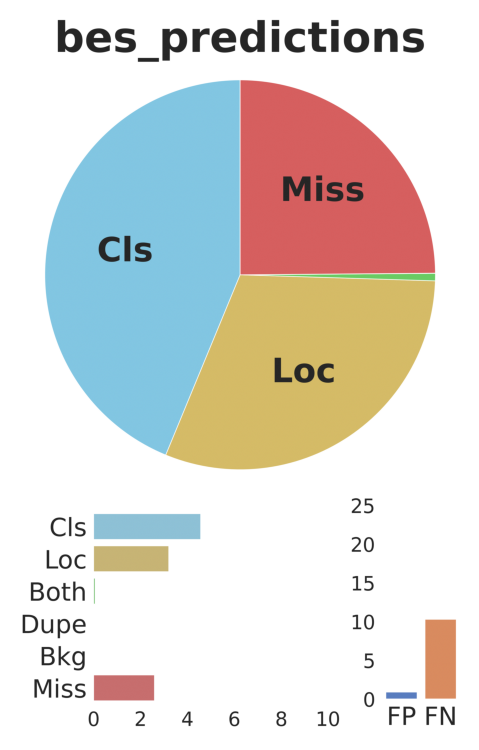

In [32]:
# ✅ Predictions saved to: ../not_tracked_dir/output_perceiver_detection_2025-08-08_07-42-02/checkpoint_epoch_14_predictions.json
# ✅ Ground truth saved to: ../not_tracked_dir/output_perceiver_detection_2025-08-08_07-42-02/checkpoint_epoch_14_ground_truth.json

from tidecv import TIDE, datasets

gt_path = '../not_tracked_dir/output_yolo_v8_2025-07-182/weights/bes_ground_truth.json' #'../not_tracked_dir/output_perceiver_detection_2025-08-08_07-42-02/checkpoint_epoch_14_ground_truth.json'
pr_path = '../not_tracked_dir/output_yolo_v8_2025-07-182/weights/bes_predictions.json' #'../not_tracked_dir/output_perceiver_detection_2025-08-08_07-42-02/checkpoint_epoch_14_predictions.json'

tide = TIDE()
tide.evaluate_range(datasets.COCO(path=gt_path), datasets.COCOResult(pr_path), pos_threshold=0.9, mode=TIDE.BOX) # Use TIDE.MASK for masks
tide.summarize()  # Summarize the results as tables in the console
tide.plot()       # Show a summary figure. Specify a folder and it'll output a png to that folder.

-- bes_predictions --

bbox AP @ [50-95]: 81.10
                                         bbox AP @ [50-95]
===================================================================================================
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      82.51    82.47    82.40    82.35    82.23    82.06    81.58    81.10    79.71    74.61  
===================================================================================================

                         Main Errors
=============================================================
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     4.91     0.39     0.00     0.06     8.88     1.63  
=============================================================

        Special Error
=============================
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       9.67       6.91  
=============================